# FoldTree2 Model Training and Analysis

This notebook trains a protein structure prediction model using FoldTree2's encoder-decoder architecture. The model learns to encode protein structures into discrete embeddings and decode them back to predict amino acid sequences and structural contacts.

## Training Process
The notebook demonstrates:
- **Vector Quantized Encoding**: Proteins are encoded into discrete embedding sequences using a transformer-based encoder
- **Multi-task Decoding**: The decoder predicts amino acid sequences, contact maps, and geometric properties
- **Progressive Learning**: Training occurs over multiple epochs with various loss components (reconstruction, contact prediction, VQ regularization)

## Training Visualizations
During training, the notebook generates comprehensive analysis plots showing:
- **Contact Prediction**: Predicted vs. true contact maps for protein residue interactions
- **Distance Analysis**: True distance matrices and binary contact classifications
- **Performance Metrics**: ROC curves and precision-recall analysis for contact prediction accuracy
- **Sequence Embedding**: Color-coded visualization of the discrete embedding alphabet learned by the model
- **3D Structure**: Interactive molecular visualization colored by embedding states
- **Bond Angles**: Comparison of predicted vs. true backbone bond angles

This provides real-time feedback on model performance across sequence, contact, and geometric prediction tasks.

In [1]:
#use autoreload
%load_ext autoreload
%autoreload 2

In [2]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [3]:
# Imports
import torch
from torch_geometric.data import DataLoader
import numpy as np
from foldtree2.src import pdbgraph
from foldtree2.src import encoder as ecdr
from foldtree2.src.losses.losses import recon_loss_diag , aa_reconstruction_loss, angles_reconstruction_loss


In [4]:

import os
import tqdm
import random
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler


In [5]:
# Import transformers schedulers
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup, get_polynomial_decay_schedule_with_warmup

In [6]:
# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

reload = False
# Data setup
datadir = '../../datasets/foldtree2/'
#dataset_path = 'structs_traininffttest.h5'
dataset_path = 'structs_train_final.h5'
converter = pdbgraph.PDB2PyG(aapropcsv='./foldtree2/config/aaindex1.csv')
struct_dat = pdbgraph.StructureDataset(dataset_path)
train_loader = DataLoader(struct_dat, batch_size=5, shuffle=True, num_workers=4)

data_sample = next(iter(train_loader))

/home/dmoi/miniforge3/envs/foldtree2/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
#print the cuda devices available and their specs
if torch.cuda.is_available():
	for i in range(torch.cuda.device_count()):
		print(f"Device {i}: {torch.cuda.get_device_name(i)}")
		print(f"  Memory Allocated: {torch.cuda.memory_allocated(i)} bytes")
		print(f"  Memory Cached: {torch.cuda.memory_reserved(i)} bytes")
else:
	print("No CUDA devices available.")

Device 0: NVIDIA RTX PRO 4000 Blackwell
  Memory Allocated: 0 bytes
  Memory Cached: 0 bytes
Device 1: NVIDIA RTX PRO 4000 Blackwell
  Memory Allocated: 0 bytes
  Memory Cached: 0 bytes


In [8]:
# Model setup

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

ndim = data_sample['res'].x.shape[1]
ndim_godnode = data_sample['godnode'].x.shape[1]
ndim_fft2i = data_sample['fourier2di'].x.shape[1]
ndim_fft2r = data_sample['fourier2dr'].x.shape[1]
print(data_sample)

HeteroDataBatch(
  identifier=[5],
  AA={
    x=[1646, 20],
    batch=[1646],
    ptr=[6],
  },
  R_true={
    x=[1646, 3, 3],
    batch=[1646],
    ptr=[6],
  },
  bondangles={
    x=[1646, 3],
    batch=[1646],
    ptr=[6],
  },
  coords={
    x=[1646, 3],
    batch=[1646],
    ptr=[6],
  },
  fourier1di={
    x=[1646, 80],
    batch=[1646],
    ptr=[6],
  },
  fourier1dr={
    x=[1646, 80],
    batch=[1646],
    ptr=[6],
  },
  fourier2di={
    x=[5, 1300],
    batch=[5],
    ptr=[6],
  },
  fourier2dr={
    x=[5, 1300],
    batch=[5],
    ptr=[6],
  },
  godnode={
    x=[5, 5],
    batch=[5],
    ptr=[6],
  },
  godnode4decoder={
    x=[5, 5],
    batch=[5],
    ptr=[6],
  },
  plddt={
    x=[1646, 1],
    batch=[1646],
    ptr=[6],
  },
  positions={
    x=[1646, 256],
    batch=[1646],
    ptr=[6],
  },
  res={
    x=[1646, 857],
    batch=[1646],
    ptr=[6],
  },
  ss={
    x=[1646, 3],
    batch=[1646],
    ptr=[6],
  },
  t_true={
    x=[1646, 3],
    batch=[1646],
    ptr=[6

In [9]:
#alphabet params
num_embeddings = 30
embedding_dim = 128

#net params
hidden_size = 150

#training params
batch_size = 10
gradient_accumulation_steps = 2
clip_grad = True
mask_plddt = True
plddt_threshold = .3

num_epochs = 300  # For demonstration, keep small

# Learning rate scheduler configuration
# Options: 'plateau', 'linear', 'cosine', 'cosine_with_restarts', 'polynomial'
scheduler_type = 'plateau'  # Change this to use different schedulers
learning_rate = 1e-5
warmup_steps = 1000  # Number of warmup steps for transformers schedulers
warmup_ratio = 0.05  # Alternative: ratio of total training steps for warmup
training_steps = len(train_loader)*num_epochs

In [10]:

#loss weights
edgeweight = 1
logitweight = 0.1
xweight = .1
fft2weight = 0.01
vqweight = 0.005
angles_weight = 0.01
ss_weight = 0.1
normalize_losses = True
use_uncertainty_weighting = True
#loss weight scheduler params
use_weight_scheduler = True

In [11]:
import math
from functools import partial	


def loss_weight_scheduler(step, total_steps, schedule_type='linear', warmup_steps=0, power=1.0, num_cycles=1):
	"""
	Loss weight scheduler that modulates weights during training.
	
	Args:
		step: Current training step
		total_steps: Total number of training steps
		schedule_type: Type of schedule ('linear', 'cosine', 'cosine_restarts', 'polynomial', 'constant')
		warmup_steps: Number of steps to warmup from 0 to 1
		power: Power for polynomial decay (only used for 'polynomial')
		num_cycles: Number of cycles for cosine with restarts
		
	Returns:
		weight: Scalar weight multiplier in range [0, 1]
	"""
	
	# Warmup phase
	if step < warmup_steps:
		return step / warmup_steps
	
	# Adjust step for post-warmup scheduling
	progress = (step - warmup_steps) / (total_steps - warmup_steps)
	progress = min(progress, 1.0)
	
	if schedule_type == 'constant':
		return 1.0
	
	elif schedule_type == 'linear':
		# Linear decay from 1.0 to 0.0
		return 1.0 - progress
	
	elif schedule_type == 'cosine':
		# Cosine annealing from 1.0 to 0.0
		return 0.5 * (1.0 + math.cos(math.pi * progress))
	
	elif schedule_type == 'cosine_restarts':
		# Cosine with hard restarts (SGDR)
		cycle_progress = (progress * num_cycles) % 1.0
		return 0.5 * (1.0 + math.cos(math.pi * cycle_progress))
	
	elif schedule_type == 'polynomial':
		# Polynomial decay
		return (1.0 - progress) ** power
	
	else:
		raise ValueError(f"Unknown schedule_type: {schedule_type}")

# Define partial functions for each loss weight scheduler

x_scheduler = partial(loss_weight_scheduler,
					  total_steps=training_steps, 
					  scheduler_type = 'linear',
					  warmup_steps=warmup_steps)

logit_scheduler = partial(loss_weight_scheduler,
					  total_steps=training_steps, 
					  scheduler_type = 'linear',
					  warmup_steps=warmup_steps)

edgeweight_scheduler = partial(loss_weight_scheduler,
					  total_steps=training_steps, 
					  scheduler_type = 'cosine_restarts',
					  num_cycles = 3,
					  warmup_steps=warmup_steps)

ss_scheduler = partial(loss_weight_scheduler,
					  total_steps=training_steps, 
					  scheduler_type = 'linear',
					  warmup_steps=warmup_steps,
					  power = 2.0)

vq_scheduler = partial(loss_weight_scheduler,
					  total_steps=training_steps, 
					  scheduler_type = 'cosine_restarts',	
					  num_cycles = 10,
					  warmup_steps=warmup_steps)
fft2_scheduler = partial(loss_weight_scheduler,
					  total_steps=training_steps, 
					  scheduler_type = 'cosine_restarts',	
					  num_cycles = 5,
					  warmup_steps=warmup_steps)
angles_scheduler = partial(loss_weight_scheduler,
 						total_steps=training_steps,
						scheduler_type = 'linear',
						warmup_steps=warmup_steps)								
													 

In [12]:
def get_scheduler(optimizer, scheduler_type, num_warmup_steps, num_training_steps , **kwargs):
	if scheduler_type == 'linear':
		return get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
	elif scheduler_type == 'cosine':
		return get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
	elif scheduler_type == 'cosine_with_restarts':
		return get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
	elif scheduler_type == 'polynomial':
		return get_polynomial_decay_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, lr_end=0.0, power=1.0)
	elif scheduler_type == 'plateau':
		# ReduceLROnPlateau doesn't require distributed process groups - it only monitors loss values
		return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,  **kwargs)
	else:
		raise ValueError(f"Unknown scheduler type: {scheduler_type}")


num_training_steps = num_epochs * len(train_loader)
if isinstance(warmup_ratio, float):
	num_warmup_steps = int(num_training_steps * warmup_ratio)
else:
	num_warmup_steps = warmup_steps

In [13]:
# Choose encoder type for Muon optimizer compatibility
print("Using Muon-compatible mk1_MuonEncoder")
encoder = ecdr.mk1_Encoder(
	in_channels=ndim,
	hidden_channels=[hidden_size, hidden_size , hidden_size],
	out_channels=embedding_dim,
	metadata={'edge_types': [('res','contactPoints','res') ]},
	num_embeddings=num_embeddings,
	commitment_cost=0.9,
	edge_dim=1,
	encoder_hidden=hidden_size,
	EMA=True,
	nheads=16,
	dropout_p=0.005,
	reset_codes=False,
	flavor='transformer',
	fftin=True,
	use_commitment_scheduling=True,
	commitment_warmup_steps=2000,
	commitment_schedule='linear',
	commitment_start=0.5,
	concat_positions=False,
	learn_positions=True
)

print(encoder)
encoder = encoder.to(device)

Seed set to 42


Using Muon-compatible mk1_MuonEncoder
mk1_Encoder(
  (position_mlp): Position_MLP(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): GELU(approximate='none')
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): GELU(approximate='none')
      (8): Dropout(p=0, inplace=False)
      (9): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (input): ModuleDict(
    (dropout): Dropout(p=0.005, inplace=False)
    (ln): LayerNorm((857,), eps=1e-06, elementwise_affine=True)
    (inmlp): Sequential(
      (0): Dropout(p=0.005, inplace=False)
      (1): LayerNorm((889,), eps=1e-06, elementwise_affine=True)
      (2): Linear(in_features=889, out_features=300, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=300, out_

In [14]:
from foldtree2.src.mono_decoders import MultiMonoDecoder

use_monodecoder = True  # Set to True to use MultiMonoDecoder, False for Single Decoder
use_muon_decoders = True  # Set to True to use Muon-compatible decoders

# MultiMonoDecoder for sequence and geometry
if use_monodecoder == True:
	'''
	
	mono_configs = {
		'sequence_transformer': {
			'in_channels': {'res': embedding_dim},
			'xdim': 20,
			'concat_positions': True,
			'hidden_channels': {('res','backbone','res'): [hidden_size] , ('res','backbonerev','res'): [hidden_size]},
			'layers': 2,
			'AAdecoder_hidden': [hidden_size, hidden_size, hidden_size//2], 
			'amino_mapper': converter.aaindex,
			'flavor': 'sage',
			'nheads': 10,
			'dropout': 0.001,
			'normalize': False,
			'residual': False,
			'use_cnn_decoder': False,
			'output_ss': False
		},
		
		'geometry_cnn': {
			'in_channels': {'res': embedding_dim, 'godnode4decoder': ndim_godnode, 'foldx': 23 ,  'fft2r': ndim_fft2r, 'fft2i': ndim_fft2i},
			'concat_positions': False, 
			'conv_channels' : [hidden_size, hidden_size//2, hidden_size//2],
			'kernel_sizes' : [3, 3, 3],
			'FFT2decoder_hidden' : [hidden_size//2, hidden_size//2],
			'contactdecoder_hidden' : [hidden_size//2, hidden_size//4],
			'ssdecoder_hidden' : [hidden_size//2, hidden_size//2],
			'Xdecoder_hidden':[hidden_size//2, hidden_size//4], 
			'anglesdecoder_hidden':[hidden_size//2, hidden_size//4],
			'RTdecoder_hidden':[hidden_size//2, hidden_size//4],
			'metadata':converter.metadata, 
			'dropout': .001,
			'output_fft': False,
			'output_rt' : False,
			'output_angles' : True,
			'output_ss' : True,
			'normalize' : True,
			'residual' : False,
			'output_edge_logits' : True,
			'ncat' : 8,
			'contact_mlp' : False,
			'pool_type' : 'global_mean'
		},
	}
	'''
	'''
	mono_configs = {
			'sequence_transformer': {
				'in_channels': {'res': embedding_dim},
				'xdim': 20,
				'concat_positions': False,
				'hidden_channels': {('res','backbone','res'): [hidden_size], ('res','backbonerev','res'): [hidden_size]},
				'layers': 2,
				'AAdecoder_hidden': [hidden_size, hidden_size, hidden_size], 
				'amino_mapper': converter.aaindex,
				'nheads': 10,
				'dropout': 0.001,
				'normalize': False,
				'residual': False,
				'use_cnn_decoder': True,
				'output_ss': False,  # Don't output SS from sequence decoder
				'learn_positions': True,
				'concat_positions': False
			},
			
			'geometry_transformer': {
				'in_channels': {'res': embedding_dim},
				'concat_positions': False,
				'hidden_channels': {('res','backbone','res'): [hidden_size], ('res','backbonerev','res'): [hidden_size]},
				'layers': 2,
				'nheads': 2,
				'RTdecoder_hidden': [hidden_size, hidden_size, hidden_size],
				'ssdecoder_hidden': [hidden_size,hidden_size, hidden_size],
				'anglesdecoder_hidden': [hidden_size, hidden_size,hidden_size],
				'dropout': 0.001,
				'normalize': False,
				'residual': False,
				'learn_positions': True,
				'use_cnn_decoder':True,
				'concat_positions': False,
				'output_rt': False,       # Enable if you want rotation-translation
				'output_ss': True,        # Secondary structure prediction
				'output_angles': True     # Bond angles prediction
			},
			
			'geometry_cnn': {
				'in_channels': {'res': embedding_dim, 'godnode4decoder': ndim_godnode, 'foldx': 23, 'fft2r': ndim_fft2r, 'fft2i': ndim_fft2i},
				'concat_positions': False,
				'conv_channels': [2*hidden_size, hidden_size, hidden_size],
				'kernel_sizes': [3, 3 ,3 ],
				'FFT2decoder_hidden': [hidden_size//2, hidden_size//2],
				'contactdecoder_hidden': [hidden_size//2, hidden_size//4],
				'ssdecoder_hidden': [hidden_size//2, hidden_size//2],
				'Xdecoder_hidden': [hidden_size, hidden_size], 
				'anglesdecoder_hidden': [hidden_size, hidden_size, hidden_size//2],
				'RTdecoder_hidden': [hidden_size//2, hidden_size//4],
				'metadata': converter.metadata, 
				'dropout': 0.001,
				'output_fft': False,
				'output_rt': False,
				'output_angles': False,   # Don't duplicate angles from geometry_transformer
				'output_ss': False,       # Don't duplicate SS from geometry_transformer
				'normalize': True,
				'residual': False,
				'output_edge_logits': True,
				'ncat': 8,
				'contact_mlp': False,
				'pool_type': 'global_mean',
				'learn_positions': True,
				'concat_positions': False
			},
		}
	'''

	mono_configs = {
			'sequence_cnn': {
				'in_channels': {'res': embedding_dim},
				'xdim': 20,
				'kernel_sizes': [3, 3 ,3 ],
				'concat_positions': False,
				'hidden_channels': {('res','backbone','res'): [hidden_size], ('res','backbonerev','res'): [hidden_size]},
				'layers': 2,
				'AAdecoder_hidden': [hidden_size, hidden_size, hidden_size], 
				'amino_mapper': converter.aaindex,
				'dropout': 0.001,
				'normalize': False,
				'residual': False,
				'output_ss': False,  # Don't output SS from sequence decoder
				'learn_positions': False,
				'concat_positions': False
			},
			
			
			'geometry_cnn': {
				'in_channels': {'res': embedding_dim, 'godnode4decoder': ndim_godnode, 'foldx': 23, 'fft2r': ndim_fft2r, 'fft2i': ndim_fft2i},
				'concat_positions': False,
				'conv_channels': [2*hidden_size, hidden_size, hidden_size],
				'kernel_sizes': [3, 3 ,3 ],
				'FFT2decoder_hidden': [hidden_size//2, hidden_size//2],
				'contactdecoder_hidden': [hidden_size//2, hidden_size//4],
				'ssdecoder_hidden': [hidden_size//2, hidden_size//2],
				'Xdecoder_hidden': [hidden_size, hidden_size], 
				'anglesdecoder_hidden': [hidden_size, hidden_size, hidden_size//2],
				'RTdecoder_hidden': [hidden_size//2, hidden_size//4],
				'metadata': converter.metadata, 
				'dropout': 0.001,
				'output_fft': False,
				'output_rt': False,
				'output_angles': False,   # Don't duplicate angles from geometry_transformer
				'output_ss': False,       # Don't duplicate SS from geometry_transformer
				'normalize': True,
				'residual': False,
				'output_edge_logits': True,
				'ncat': 8,
				'contact_mlp': False,
				'pool_type': 'global_mean',
				'learn_positions': True,
				'concat_positions': False
			},
		}
	decoder = MultiMonoDecoder(configs=mono_configs)
else:
	# Single decoder 
	decoder = ecdr.HeteroGAE_Decoder(
			in_channels={'res': embedding_dim , 'godnode4decoder': ndim_godnode, 'foldx': 23},
			concat_positions=False,
			hidden_channels={('res','backbone','res'): [hidden_size]*5, ('res','backbonerev','res'): [hidden_size]*5, ('res','informs','godnode4decoder'): [hidden_size]*5 , ('godnode4decoder','informs','res'): [hidden_size]*5},
			layers=3,
			AAdecoder_hidden=[hidden_size, hidden_size, hidden_size//2],
			Xdecoder_hidden=[hidden_size, hidden_size, hidden_size],
			contactdecoder_hidden=[hidden_size//2, hidden_size//2],
			anglesdecoder_hidden=[hidden_size//2,hidden_size//2, hidden_size//4],
			nheads=5,
			amino_mapper=converter.aaindex,
			flavor='sage',
			dropout=0.005,
			normalize=True,
			residual=False,
			contact_mlp=False
		)
decoder = decoder.to(device)
print(decoder)


'''
		'contacts': {
			'in_channels': {'res': embedding_dim, 'godnode4decoder': ndim_godnode, 'foldx': 23 ,  'fft2r': ndim_fft2r, 'fft2i': ndim_fft2i},
			'concat_positions': True,
			'hidden_channels': {('res','backbone','res'): [hidden_size//2]*1 , ('res','backbonerev','res'): [hidden_size//2]*1 , ('res','informs','godnode4decoder'): [hidden_size//2]*1 , ('godnode4decoder','informs','res'): [hidden_size//2]*1},
			'layers': 2,
			'FFT2decoder_hidden' : [hidden_size//2, hidden_size//2],
			'contactdecoder_hidden' : [hidden_size//2, hidden_size//4],
			'ssdecoder_hidden' : [hidden_size//2, hidden_size//2],
			'Xdecoder_hidden': [hidden_size, hidden_size, hidden_size//2, hidden_size//2], 
			'anglesdecoder_hidden': [hidden_size, hidden_size, hidden_size//4],
			'RTdecoder_hidden': [hidden_size//2, hidden_size//2],
			'nheads': 5,
			'amino_mapper': converter.aaindex,
			'flavor': 'transformer',
			'dropout': .001,
			'output_fft': False,
			'output_rt' : False,
			'output_angles' : True,
			'output_ss' : True,
			'normalize' : True,
			'residual' : False,
			'contact_mlp' : False,
			'ncat': 16,
			'output_edge_logits': True
		},
	'''

Seed set to 42
Seed set to 42


Initializing decoder for task: sequence_cnn
False False False False False
Initializing decoder for task: geometry_cnn
False False False False False
MultiMonoDecoder(
  (decoders): ModuleDict(
    (sequence_cnn): CNN_AA_Decoder(
      (input): ModuleDict(
        (dropout): Dropout(p=0.001, inplace=False)
        (proj): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=128, out_features=128, bias=True)
          (3): GELU(approximate='none')
        )
      )
      (body): ModuleDict(
        (convs): ModuleList(
          (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
          (2): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (norms): ModuleList(
          (0): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (1): LayerNorm((256,), eps=1

"\n\t\t'contacts': {\n\t\t\t'in_channels': {'res': embedding_dim, 'godnode4decoder': ndim_godnode, 'foldx': 23 ,  'fft2r': ndim_fft2r, 'fft2i': ndim_fft2i},\n\t\t\t'concat_positions': True,\n\t\t\t'hidden_channels': {('res','backbone','res'): [hidden_size//2]*1 , ('res','backbonerev','res'): [hidden_size//2]*1 , ('res','informs','godnode4decoder'): [hidden_size//2]*1 , ('godnode4decoder','informs','res'): [hidden_size//2]*1},\n\t\t\t'layers': 2,\n\t\t\t'FFT2decoder_hidden' : [hidden_size//2, hidden_size//2],\n\t\t\t'contactdecoder_hidden' : [hidden_size//2, hidden_size//4],\n\t\t\t'ssdecoder_hidden' : [hidden_size//2, hidden_size//2],\n\t\t\t'Xdecoder_hidden': [hidden_size, hidden_size, hidden_size//2, hidden_size//2], \n\t\t\t'anglesdecoder_hidden': [hidden_size, hidden_size, hidden_size//4],\n\t\t\t'RTdecoder_hidden': [hidden_size//2, hidden_size//2],\n\t\t\t'nheads': 5,\n\t\t\t'amino_mapper': converter.aaindex,\n\t\t\t'flavor': 'transformer',\n\t\t\t'dropout': .001,\n\t\t\t'output_f

In [15]:
from foldtree2.src.losses.losses import UncertaintyWeighting
if use_uncertainty_weighting:
	uncertainy_weighting = UncertaintyWeighting(task_names=['aa_loss', 'edge_loss', 'vq_loss', 'fft2_loss', 'angles_loss', 'ss_loss', 'logit_loss'], device=device)


In [16]:
# Training loop setup
import time
from collections import defaultdict
from muon import MuonWithAuxAdam

#pip install git+https://github.com/KellerJordan/Muon

use_muon = False  # Set to True to use MuonWithAuxAdam optimizer, False for AdamW

encoder.device = device
encoder.train()
decoder.train()

if use_muon == False:
	# Initialize optimizer
	if use_uncertainty_weighting:
		print("Using AdamW optimizer for encoder, decoder, and uncertainty weighting parameters")
		optimizer = torch.optim.AdamW([
			{'params': list(encoder.parameters()) + list(decoder.parameters()), 'lr': learning_rate},
			{'params': uncertainy_weighting.parameters(), 'lr': learning_rate/10}
		])
	else:
		print("Using AdamW optimizer for encoder and decoder parameters only")
		optimizer = torch.optim.AdamW(
			list(encoder.parameters()) + list(decoder.parameters()), 
			lr=learning_rate
		)
else:
	hidden_weights = []
	hidden_gains_biases = []
	nonhidden_params = []
	
	# Helper function to check if a model has modular structure
	def has_modular_structure(model):
		return hasattr(model, 'input') and hasattr(model, 'body') and hasattr(model, 'head')
	
	# Process encoder
	if has_modular_structure(encoder):
		print("Using modular encoder structure")
		hidden_weights += [p for p in encoder.body.parameters() if p.ndim >= 2]
		hidden_gains_biases += [p for p in encoder.body.parameters() if p.ndim < 2]
		nonhidden_params += [*encoder.head.parameters(), *encoder.input.parameters()]
	else:
		print("Encoder is not modular - using AdamW for all encoder parameters")
		nonhidden_params += list(encoder.parameters())
	
	# Process decoder
	if hasattr(decoder, 'decoders'):
		# MultiMonoDecoder case
		print(f"Using MultiMonoDecoder with {len(decoder.decoders)} sub-decoders")
		for name, subdecoder in decoder.decoders.items():
			if has_modular_structure(subdecoder):
				print(f"  - {name}: modular structure detected")
				hidden_weights += [p for p in subdecoder.body.parameters() if p.ndim >= 2]
				hidden_gains_biases += [p for p in subdecoder.body.parameters() if p.ndim < 2]
				nonhidden_params += [*subdecoder.head.parameters(), *subdecoder.input.parameters()]
			else:
				print(f"  - {name}: non-modular, using AdamW")
				nonhidden_params += list(subdecoder.parameters())
	elif has_modular_structure(decoder):
		# Single modular decoder
		print("Using modular single decoder structure")
		hidden_weights += [p for p in decoder.body.parameters() if p.ndim >= 2]
		hidden_gains_biases += [p for p in decoder.body.parameters() if p.ndim < 2]
		nonhidden_params += [*decoder.head.parameters(), *decoder.input.parameters()]
	else:
		# Single non-modular decoder
		print("Decoder is not modular - using AdamW for all decoder parameters")
		nonhidden_params += list(decoder.parameters())
	
	# Print parameter group summary
	print(f"\nParameter groups for Muon optimizer:")
	print(f"  Hidden weights (Muon):           {len(hidden_weights)} tensors")
	print(f"  Hidden gains/biases (AdamW):     {len(hidden_gains_biases)} tensors")
	print(f"  Non-hidden params (AdamW):       {len(nonhidden_params)} tensors")
	
	param_groups = [
		dict(params=hidden_weights, use_muon=True,
			lr=0.02, weight_decay=0.001),
		dict(params=hidden_gains_biases+nonhidden_params, use_muon=False,
			lr=1e-4, betas=(0.9, 0.95), weight_decay=0.001),
	]
	if use_uncertainty_weighting:
		param_groups.append(dict(params=uncertainy_weighting.parameters(), use_muon=False, lr=learning_rate))

	optimizer = MuonWithAuxAdam(param_groups)

# Calculate total training steps for schedulers
num_training_steps = num_epochs * len(train_loader)
print(f"Total training steps: {num_training_steps}")
print(f"Warmup steps: {warmup_steps if warmup_steps else int(num_training_steps * warmup_ratio)}")

# Initialize scheduler based on configuration

scheduler = get_scheduler(
	optimizer, 
	scheduler_type=scheduler_type,
	num_training_steps=num_training_steps,
	num_warmup_steps=warmup_steps if warmup_steps else int(num_training_steps * warmup_ratio),
)

scheduler_step_mode = 'epoch' if scheduler_type == 'plateau' else 'step'

print(f"Using {scheduler_type} scheduler with step mode: {scheduler_step_mode}")

Using AdamW optimizer for encoder, decoder, and uncertainty weighting parameters
Total training steps: 300000
Warmup steps: 1000
Using plateau scheduler with step mode: epoch


## Muon Optimizer Training

The Muon optimizer uses a hybrid approach:
- **Muon optimizer** for hidden layer weights (2D+ tensors in body modules) - uses momentum-based Newton updates
- **AdamW optimizer** for gains, biases, and non-hidden parameters (input/head modules)

This configuration is optimal for deep networks with modular architectures where:
- Body modules contain the core transformations (graph convolutions, CNNs, transformers)
- Input/Head modules handle preprocessing and task-specific outputs

**Current Configuration:**
- Encoder: `mk1_MuonEncoder` with input/body/head structure
- Decoders: `Transformer_AA_MuonDecoder` and `CNN_geo_MuonDecoder`
- Muon LR: 0.02 (for hidden weights)
- AdamW LR: 3e-4 (for gains/biases and other params)

In [17]:
# Verify Muon setup
if use_muon:
	print("\n" + "="*60)
	print("MUON OPTIMIZER CONFIGURATION")
	print("="*60)
	

	import os as dist_os
	import torch.distributed as dist
	
	# Clean up any existing process group
	if dist.is_initialized():
		dist.destroy_process_group()
		print("Destroyed existing process group")
	
	# Find an available port
	import socket
	def find_free_port():
		with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
			s.bind(('', 0))
			s.listen(1)
			port = s.getsockname()[1]
		return port
	
	free_port = find_free_port()
	
	dist_os.environ['MASTER_ADDR'] = 'localhost'
	dist_os.environ['MASTER_PORT'] = str(free_port)
	dist_os.environ['RANK'] = '0'
	dist_os.environ['WORLD_SIZE'] = '1'
	dist.init_process_group(backend='gloo', init_method='env://')
	print(f"Initialized single-process group for Muon optimizer on port {free_port}")

	# Check encoder structure
	print(f"\nEncoder type: {type(encoder).__name__}")
	if hasattr(encoder, 'input') and hasattr(encoder, 'body') and hasattr(encoder, 'head'):
		print("✓ Encoder has modular structure (input/body/head)")
		print(f"  - Input modules: {list(encoder.input.keys())}")
		print(f"  - Body modules: {list(encoder.body.keys())}")
		print(f"  - Head modules: {list(encoder.head.keys())}")
	else:
		print("✗ Encoder is not modular - will use AdamW only")
	
	# Check decoder structure
	print(f"\nDecoder type: {type(decoder).__name__}")
	if hasattr(decoder, 'decoders'):
		print(f"✓ MultiMonoDecoder with {len(decoder.decoders)} sub-decoders:")
		for name, subdecoder in decoder.decoders.items():
			if hasattr(subdecoder, 'input') and hasattr(subdecoder, 'body') and hasattr(subdecoder, 'head'):
				print(f"  ✓ {name}: {type(subdecoder).__name__} - modular")
			else:
				print(f"  ✗ {name}: {type(subdecoder).__name__} - non-modular")
	
	# Count total parameters
	encoder_params = sum(p.numel() for p in encoder.parameters())
	decoder_params = sum(p.numel() for p in decoder.parameters())
	total_params = encoder_params + decoder_params
	
	print(f"\nParameter counts:")
	print(f"  Encoder: {encoder_params:,}")
	print(f"  Decoder: {decoder_params:,}")
	print(f"  Total:   {total_params:,}")
	
	print("\nOptimizer parameter groups:")
	for i, group in enumerate(optimizer.param_groups):
		num_params = sum(p.numel() for p in group['params'])
		use_muon_flag = group.get('use_muon', False)
		lr = group.get('lr', 'N/A')
		print(f"  Group {i}: {'Muon' if use_muon_flag else 'AdamW':<6} | LR={lr:<8} | {num_params:,} params")
	
	print("="*60)
else:
	print("\nUsing standard AdamW optimizer (use_muon=False)")
	total_params = sum(p.numel() for p in encoder.parameters()) + sum(p.numel() for p in decoder.parameters())
	print(f"Total parameters: {total_params:,}")


Using standard AdamW optimizer (use_muon=False)
Total parameters: 4,582,663


In [18]:
#get one sample from the dataloader
train_loader = DataLoader(struct_dat, batch_size=1, shuffle=True, num_workers=4)
import random
randint = random.randint(0, len(train_loader) - 1)
print(f"Randomly selected batch index: {randint}")
data_sample = struct_dat[randint]
print(data_sample)
data = data_sample.to(device)
optimizer.zero_grad()
z, vqloss = encoder(data , debug = True)
print('Encoded z shape:', z.shape)

Randomly selected batch index: 912
HeteroData(
  identifier='A0A1M3NAL2',
  AA={ x=[114, 20] },
  R_true={ x=[114, 3, 3] },
  bondangles={ x=[114, 3] },
  coords={ x=[114, 3] },
  fourier1di={ x=[114, 80] },
  fourier1dr={ x=[114, 80] },
  fourier2di={ x=[1, 1300] },
  fourier2dr={ x=[1, 1300] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  plddt={ x=[114, 1] },
  positions={ x=[114, 256] },
  res={ x=[114, 857] },
  ss={ x=[114, 3] },
  t_true={ x=[114, 3] },
  (godnode4decoder, informs, res)={ edge_index=[2, 114] },
  (godnode, informs, res)={ edge_index=[2, 114] },
  (res, backbone, res)={
    edge_index=[2, 227],
    edge_attr=[113],
  },
  (res, backbonerev, res)={
    edge_index=[2, 227],
    edge_attr=[113],
  },
  (res, contactPoints, res)={
    edge_index=[2, 4722],
    edge_attr=[4722],
  },
  (res, hbond, res)={
    edge_index=[2, 170],
    edge_attr=[170],
  },
  (res, informs, godnode)={ edge_index=[2, 114] },
  (res, informs, godnode4decoder)={ edge_index=[2,

In [19]:
# Filter proteins with at least 200 amino acids and average plddt > 0.7
import random
import json
check_plddt = False
if check_plddt == True or os.path.exists('plddt_dataset.json') == False:
	# Collect valid protein indices
	valid_indices = []
	for idx in range(len(struct_dat)):
		try:
			data = struct_dat[idx]
			num_residues = data['AA'].x.shape[0]
			avg_plddt = data['plddt'].x.mean().item()
			
			if num_residues >= 200 and avg_plddt > 0.7:
				valid_indices.append(idx)
				print(f"Index {idx}: {data.identifier}, {num_residues} residues, avg pLDDT={avg_plddt:.3f}")
		except Exception as e:
			continue

	print(f"\nFound {len(valid_indices)} proteins with ≥200 residues and avg pLDDT > 0.7")
	with open( 'plddt_dataset.json' , 'w') as fileout:
		fileout.write( json.dumps(valid_indices) )
else:
	with open( 'plddt_dataset.json' ) as fileout:
		valid_indices = json.load(fileout)
#save valid indices


if len(valid_indices) > 0:
	# Select random protein from valid ones
	selected_idx = random.choice(valid_indices)
	selected_protein = struct_dat[selected_idx]
	
	print(f"\n{'='*60}")
	print(f"SELECTED PROTEIN:")
	print(f"  Identifier: {selected_protein.identifier}")
	print(f"  Number of residues: {selected_protein['AA'].x.shape[0]}")
	print(f"  Average pLDDT: {selected_protein['plddt'].x.mean().item():.3f}")
	print(f"  Dataset index: {selected_idx}")
	print(f"{'='*60}")
else:
	print("No proteins found matching the criteria!")
	selected_protein = None
	selected_idx = None


SELECTED PROTEIN:
  Identifier: A0A0F8ZIU5
  Number of residues: 200
  Average pLDDT: 0.721
  Dataset index: 280


In [20]:
from Bio import PDB
from Bio.PDB import PDBParser
from foldtree2.src.AFDB_tools import grab_struct

def getCAatoms(pdb_file):
	parser = PDBParser(QUIET=True)
	# Parse the structure
	structure = parser.get_structure('structure', pdb_file)
	ca_atoms = []
	for model in structure:
		for chain in model:
			for residue in chain :
				if 'CA' in residue and PDB.is_aa(residue) :
					ca_atoms.append(residue['CA'])
	return ca_atoms

In [21]:
#get aa and contacts

from torch_geometric.data import DataLoader , HeteroData
from scipy import sparse
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
#add precision and recall metrics
from sklearn.metrics import precision_recall_curve, average_precision_score

def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
	decoder.eval()
	z = encoder.vector_quantizer.embeddings( ords  ).to('cpu')
	
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	godnode_index = np.vstack([np.zeros(z.shape[0]), [ i for i in range(z.shape[0]) ] ])
	godnode_rev = np.vstack([ [ i for i in range(z.shape[0]) ] , np.zeros(z.shape[0]) ])
	#generate a backbone for the decoder
	data = HeteroData()
	
	data['res'].x = z
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
	data['res'].batch = torch.tensor([0 for i in range(z.shape[0])], dtype=torch.long)
	data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data[ 'res' , 'backbone_rev' , 'res'].edge_index = torch.tensor(backbone_rev, dtype=torch.long)
	#add the godnode
	data['godnode'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder', 'informs', 'res'].edge_index = torch.tensor(godnode_index, dtype=torch.long)
	data['res', 'informs', 'godnode4decoder'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	data['res', 'informs', 'godnode'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	edge_index = edge_index.to( device )
	data = data.to( device )
	allpairs = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	out = decoder( data , allpairs )
	recon_x = out['aa'] if 'aa' in out else None
	edge_probs = out['edge_probs'] if 'edge_probs' in out else None
	logits = out['edge_logits'] if 'edge_logits' in out else None
	if 'sequence_transformer' in decoder.decoders:
		amino_map = decoder.decoders['sequence_transformer'].amino_acid_indices
	else:
		amino_map = decoder.decoders['sequence_cnn'].amino_acid_indices
		
	revmap_aa = { v:k for k,v in amino_map.items() }
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	#watch out... ss str has codes more than 1 letter long sometimes. just map them to single number codes for hamming distance calculation
	if 'ss_pred' in out and out['ss_pred'] is not None:
		ssstr = ''.join(str(int(idx.item())) for idx in out['ss_pred'].argmax(dim=1) ) if 'ss_pred' in out else None
	else:
		ssstr = None
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	logits = torch.sum( logits , dim=1).squeeze()
	logits = logits.reshape((z.shape[0], z.shape[0]))
	return aastr ,edge_probs, logits , out , ssstr

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import colour
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_logits_sequence_on_ax(selected_indices, num_embeddings, ax, max_width=64, line_spacing=1, show_title=True, show_colorbar=False):
	"""
	Plots a wrapped embedding sequence using argmax from logits on a given matplotlib Axes.
	
	Parameters:
		logits (np.ndarray): Array of shape (sequence_length, num_embeddings).
		num_embeddings (int): Number of possible embeddings.
		ax (matplotlib.axes.Axes): Target axis to draw the plot.
		max_width (int): Max tokens per line.
		line_spacing (int): White lines between sequences.
		show_title (bool): If True, show a title on the subplot.
		show_colorbar (bool): If True, attach a colorbar to the plot.
	"""
	################ Process inputs
	selected_indices = np.array(selected_indices)
	# Create color mapping
	ord_colors = colour.Color("red").range_to(colour.Color("blue"), num_embeddings)
	ord_colors = np.array([c.get_rgb() for c in ord_colors])
	sequence_colors = ord_colors[selected_indices]

	# Compute rows and canvas
	total_len = len(selected_indices)
	rows = int(np.ceil(total_len / max_width))
	height = rows * (1 + line_spacing) - line_spacing
	canvas = np.ones((height, max_width, 3))  # White background

	for i in range(rows):
		start = i * max_width
		end = min((i + 1) * max_width, total_len)
		row_colors = sequence_colors[start:end]
		row_y = i * (1 + line_spacing)
		canvas[row_y, :len(row_colors), :] = row_colors

	# Plot on given axis
	ax.imshow(canvas, aspect='auto')
	ax.axis('off')
	if show_title:
		ax.set_title("Embedding Selection (argmax)")

	# Optional colorbar
	if show_colorbar:
		from matplotlib.colors import ListedColormap
		cmap = ListedColormap(ord_colors)
		norm = plt.Normalize(vmin=0, vmax=num_embeddings - 1)
		sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
		sm.set_array([])
		plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.01)

def hamming(pred, true):
	if pred is None or true is None:
		return None, None
	if len(pred) != len(true):
		raise ValueError("Strings must be of the same length for Hamming distance calculation.")
	mism = sum(p != t for p, t in zip(pred, true))
	n = len(pred)
	return mism / n, mism  # (fraction, count)

def visualize_decoder_reconstruction(encoder, decoder, data_sample, device, num_embeddings, 
									converter, epoch=None, save_path=None, figsize=(20, 12)):
	"""
	Comprehensive visualization of encoder-decoder reconstruction performance.
	
	Args:
		encoder: Trained encoder model
		decoder: Trained decoder model
		data_sample: Single protein structure data sample
		device: PyTorch device
		num_embeddings: Size of discrete embedding alphabet
		converter: PDB2PyG converter for protein processing
		epoch: Optional epoch number for titles
		save_path: Optional path to save figure
		figsize: Figure size tuple
		
	Returns:
		fig: matplotlib figure
		metrics_dict: Dictionary containing computed metrics
	"""
	
	encoder.eval()
	decoder.eval()
	
	# Encode the structure
	data_sample = data_sample.to(device)
	with torch.no_grad():
		z, vqloss = encoder(data_sample)
		ords = encoder.vector_quantizer.discretize_z(z.detach())
		zdiscrete = ords[0].detach()
	
	# Reconstruct from discrete embeddings
	aastr, edge_probs, logits, sample_out , ssstr = decoder_reconstruction2aa(zdiscrete, device, verbose=True)
	revindex = {v:k for k,v in converter.aaindex.items()}
	aatrue = ''.join(revindex[int(idx.item())] for idx in np.array(data_sample['AA'].x.argmax(dim=1).cpu()) )
	sstrue = ''.join(str(int(idx.item())) for idx in data_sample['ss'].x.argmax(dim=1).cpu()) 
	# Compute Hamming distance for sequence and secondary structure
	seq_hamming_frac, seq_hamming_count = hamming(aastr, aatrue)
	ss_hamming_frac, ss_hamming_count = hamming(ssstr, sstrue)

	print(f"Sequence Hamming Distance: {seq_hamming_frac:.3f} ({seq_hamming_count} mismatches)")
	if ssstr is not None and sstrue is not None:
		print(f"Secondary Structure Hamming Distance: {ss_hamming_frac:.3f} ({ss_hamming_count} mismatches)")

	# Get structure and compute distance matrix
	grab_struct(str(data_sample.identifier), structfolder='tmp/')
	ca_atoms = getCAatoms('tmp/' + str(data_sample.identifier) + '.pdb')
	dist_mat = np.zeros((len(ca_atoms), len(ca_atoms)))
	
	for i, res1 in enumerate(ca_atoms):
		for j, res2 in enumerate(ca_atoms):
			if i < j:
				dist_mat[i, j] = np.linalg.norm(res1.coord - res2.coord)
	dist_mat += dist_mat.T  # Make symmetric
	np.fill_diagonal(dist_mat, 0)
	
	# Binary contact matrix (10Å cutoff)
	ndistmat = dist_mat.copy()
	ndistmat[dist_mat > 15] = 0
	ndistmat[dist_mat <= 15] = 1
	
	# Create figure
	fig, axs = plt.subplots(3, 3, figsize=figsize)
	epoch_str = f"Epoch {epoch} - " if epoch is not None else ""
	
	# Row 1: Contact maps and distance matrices
	# Predicted Contacts
	im0 = axs[0, 0].imshow(1 - edge_probs.detach().cpu().numpy(), cmap='hot', interpolation='nearest')
	axs[0, 0].set_title(f"{epoch_str}Predicted Contacts for {data_sample.identifier}")
	fig.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)
	
	# True Distance Matrix
	im1 = axs[0, 1].imshow(dist_mat, cmap='hot', interpolation='nearest')
	axs[0, 1].set_title(f"{epoch_str}Distance Matrix for {data_sample.identifier}")
	fig.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)
	
	# Binary Contacts (10Å cutoff)
	im2 = axs[0, 2].imshow(ndistmat, cmap='hot', interpolation='nearest')
	axs[0, 2].set_title(f"{epoch_str}True Contacts (<10Å)")
	fig.colorbar(im2, ax=axs[0, 2], fraction=0.046, pad=0.04)
	
	# Row 2: Performance metrics
	edge_probs_np = edge_probs.detach().cpu().numpy()
	edge_probs_np = edge_probs_np.reshape((z.shape[0], z.shape[0]))
	ndistmat_flat = ndistmat.flatten()
	edge_probs_flat = edge_probs_np.flatten()
	
	# ROC Curve (all residues)
	fpr, tpr, _ = roc_curve(ndistmat_flat, edge_probs_flat)
	roc_auc = auc(fpr, tpr)
	axs[1, 0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
	axs[1, 0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
	axs[1, 0].set_xlim([0.0, 1.0])
	axs[1, 0].set_ylim([0.0, 1.05])
	
	# ROC Curve (off-diagonal only, |i-j| >= 10)
	mask = np.fromfunction(lambda i, j: np.abs(i - j) >= 10, dist_mat.shape)
	masked_ndistmat = np.where(mask, ndistmat, np.nan)
	masked_edge_probs = np.where(mask, edge_probs_np, np.nan)
	
	ndistmat_flat_masked = masked_ndistmat.flatten()
	edge_probs_flat_masked = masked_edge_probs.flatten()
	valid_mask = ~np.isnan(ndistmat_flat_masked) & ~np.isnan(edge_probs_flat_masked)
	ndistmat_flat_masked = ndistmat_flat_masked[valid_mask]
	edge_probs_flat_masked = edge_probs_flat_masked[valid_mask]
	
	fpr_offdiag, tpr_offdiag, _ = roc_curve(ndistmat_flat_masked, edge_probs_flat_masked)
	roc_auc_offdiag = auc(fpr_offdiag, tpr_offdiag)
	axs[1, 0].plot(fpr_offdiag, tpr_offdiag, color='red', lw=2, 
				   label=f'ROC offdiag (area = {roc_auc_offdiag:.2f})')
	
	axs[1, 0].set_xlabel('False Positive Rate')
	axs[1, 0].set_ylabel('True Positive Rate')
	axs[1, 0].set_title('Receiver Operating Characteristic')
	axs[1, 0].legend(loc='lower right')
	
	# Precision-Recall Curve
	precision, recall, _ = precision_recall_curve(ndistmat_flat, edge_probs_flat)
	ap_score = average_precision_score(ndistmat_flat, edge_probs_flat)
	axs[1, 1].plot(recall, precision, color='green', lw=2, label=f'AP = {ap_score:.2f}')
	axs[1, 1].set_xlabel('Recall')
	axs[1, 1].set_ylabel('Precision')
	axs[1, 1].set_title('Precision-Recall Curve')
	axs[1, 1].legend(loc='lower left')
	
	# Correlation plot
	dist_mat_flat = dist_mat.flatten() / dist_mat.flatten().max()  # Normalize
	corr = np.corrcoef(edge_probs_flat, dist_mat_flat)[0, 1]
	axs[1, 2].scatter(edge_probs_flat, dist_mat_flat, alpha=0.05, s=0.1)
	axs[1, 2].set_xlabel('Predicted Contacts')
	axs[1, 2].set_ylabel('True Distance (normalized)')
	axs[1, 2].set_title(f'Correlation: {corr:.2f}')
	
	# Row 3: Additional predictions
	# Bond angles (if available)
	if 'angles' in sample_out and sample_out['angles'] is not None:
		true_angles = data_sample['bondangles'].x.detach().cpu().numpy()
		pred_angles = sample_out['angles'].detach().cpu().numpy()
		angle_names = ['N-Ca-C', 'Ca-C-N', 'C-N-Ca']
		angle_colors = ['r', 'g', 'b']
		
		for i in range(3):
			axs[2, 0].plot(true_angles[:, i], label='True ' + angle_names[i], 
						   color=angle_colors[i], alpha=0.5)
			axs[2, 0].plot(pred_angles[:, i], label='Pred ' + angle_names[i], 
						   color=angle_colors[i], linestyle='--', alpha=0.5)
		axs[2, 0].legend()
		axs[2, 0].set_title('Bond Angles')
		axs[2, 0].set_xlabel('Residue Index')
		axs[2, 0].set_ylabel('Angle (radians)')
	else:
		#plot the ss prediction instead using the plot logits sequence function
		if 'ss' in sample_out and sample_out['ss_pred'] is not None:
			ss_logits = sample_out['ss_pred'].detach().cpu().numpy()
			plot_logits_sequence_on_ax(ss_logits.argmax(axis=1), 3, axs[2, 0], 
									   max_width=64, show_colorbar=True)
			axs[2, 0].set_title('Predicted Secondary Structure Sequence')
	
	# Edge logits
	im3 = axs[2, 1].imshow(logits.detach().cpu().numpy(), cmap='hot', interpolation='nearest')
	axs[2, 1].set_xlabel('Residue Index')
	axs[2, 1].set_ylabel('Residue Index')
	axs[2, 1].set_title('Predicted Edge Logits')
	fig.colorbar(im3, ax=axs[2, 1], fraction=0.046, pad=0.04)
	
	# Discrete embedding sequence
	plot_logits_sequence_on_ax(zdiscrete.detach().cpu().numpy(), num_embeddings, 
							   axs[2, 2], max_width=64, show_colorbar=True)
	axs[2, 2].set_title('FoldTree2 Embedding Sequence')
	plt.tight_layout()
	
	# Save if path provided
	if save_path:
		fig.savefig(save_path, bbox_inches='tight', dpi=150)
		print(f"Saved figure to {save_path}")
	
	# Compile metrics
	metrics_dict = {
		'roc_auc': roc_auc,
		'roc_auc_offdiag': roc_auc_offdiag,
		'average_precision': ap_score,
		'correlation': corr,
		'num_residues': z.shape[0],
		'vq_loss': vqloss.item() if isinstance(vqloss, torch.Tensor) else vqloss
	}
	
	encoder.train()
	decoder.train()


	'''
	fig2 = plt.figure(figsize=(6, 4))
	#ramachandran plot
	if 'angles' in sample_out and sample_out['angles'] is not None:
		true_angles = data_sample['bondangles'].x.detach().cpu().numpy()
		pred_angles = sample_out['angles'].detach().cpu().numpy()
		axs2 = fig2.add_subplot(1, 1, 1)
		axs2.scatter(true_angles[:, 0], true_angles[:, 1], label='True', color='blue', alpha=0.5, s=10)
		axs2.scatter(pred_angles[:, 0], pred_angles[:, 1], label='Pred', color='red', alpha=0.5, s=10)
		axs2.set_xlabel('Phi (N-Ca)')
		axs2.set_ylabel('Psi (Ca-C)')
		axs2.set_title('Ramachandran Plot')
		axs2.legend()
		fig2.tight_layout()
		

	fig3, axs3 = plt.subplots(1, 3, figsize=(6, 4))
	#separate angles plot
	if 'angles' in sample_out and sample_out['angles'] is not None:
		true_angles = data_sample['bondangles'].x.detach().cpu().numpy()
		pred_angles = sample_out['angles'].detach().cpu().numpy()
		angle_names = ['N-Ca-C', 'Ca-C-N', 'C-N-Ca']
		angle_colors = ['r', 'g', 'b']
		
		for i in range(3):
			axs3[i].plot(true_angles[:, i], label='True ' + angle_names[i], 
						   color=angle_colors[i], alpha=0.5)
			axs3[i].plot(pred_angles[:, i], label='Pred ' + angle_names[i], 
						   color=angle_colors[i], linestyle='--', alpha=0.5)
			axs3[i].set_title(angle_names[i])
			axs3[i].set_xlabel('Residue Index')
			axs3[i].set_ylabel('Angle (radians)')
			axs3[i].legend()
		fig3.tight_layout()
	
	#confusion matrix for ss
	fig4 = plt.figure(figsize=(6, 4))
	if 'ss' in sample_out and sample_out['ss_pred'] is not None:
		from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
		true_ss = data_sample['ss'].x.argmax(dim=1).cpu().numpy()
		pred_ss = sample_out['ss_pred'].argmax(dim=1).cpu().numpy()
		cm = confusion_matrix(true_ss, pred_ss)
		disp = ConfusionMatrixDisplay(confusion_matrix=cm)
		disp.plot(ax=axs3[0], cmap='Blues')
		fig4.set_title('SS Confusion Matrix')
		fig4.set_xlabel('Predicted SS')
		fig4.set_ylabel('True SS')
		fig4.tight_layout()
	
	#confusion matrix for aa
	fig5 = plt.figure(figsize=(6, 4))
	if 'aa' in sample_out and sample_out['aa'] is not None:
		true_aa = data_sample['AA'].x.argmax(dim=1).cpu().numpy()
		pred_aa = sample_out['aa'].argmax(dim=1).cpu().numpy()
		cm_aa = confusion_matrix(true_aa, pred_aa)
		disp_aa = ConfusionMatrixDisplay(confusion_matrix=cm_aa)
		disp_aa.plot(ax=axs3[1], cmap='Blues')
		fig5.set_title('AA Confusion Matrix')
		fig5.set_xlabel('Predicted AA')
		fig5.set_ylabel('True AA')
		fig5.tight_layout()

	sup_figs = [fig2, fig3, fig4, fig5]
	metrics_dict['sup_figs'] = sup_figs
	'''
	return fig, metrics_dict , sample_out

Sequence Hamming Distance: 0.961 (245 mismatches)
Saved figure to reconstruction_analysis.png

Prediction Metrics:
  roc_auc: 0.5160
  roc_auc_offdiag: 0.5161
  average_precision: 0.1644
  correlation: -0.1120
  num_residues: 255
  vq_loss: 3.1552


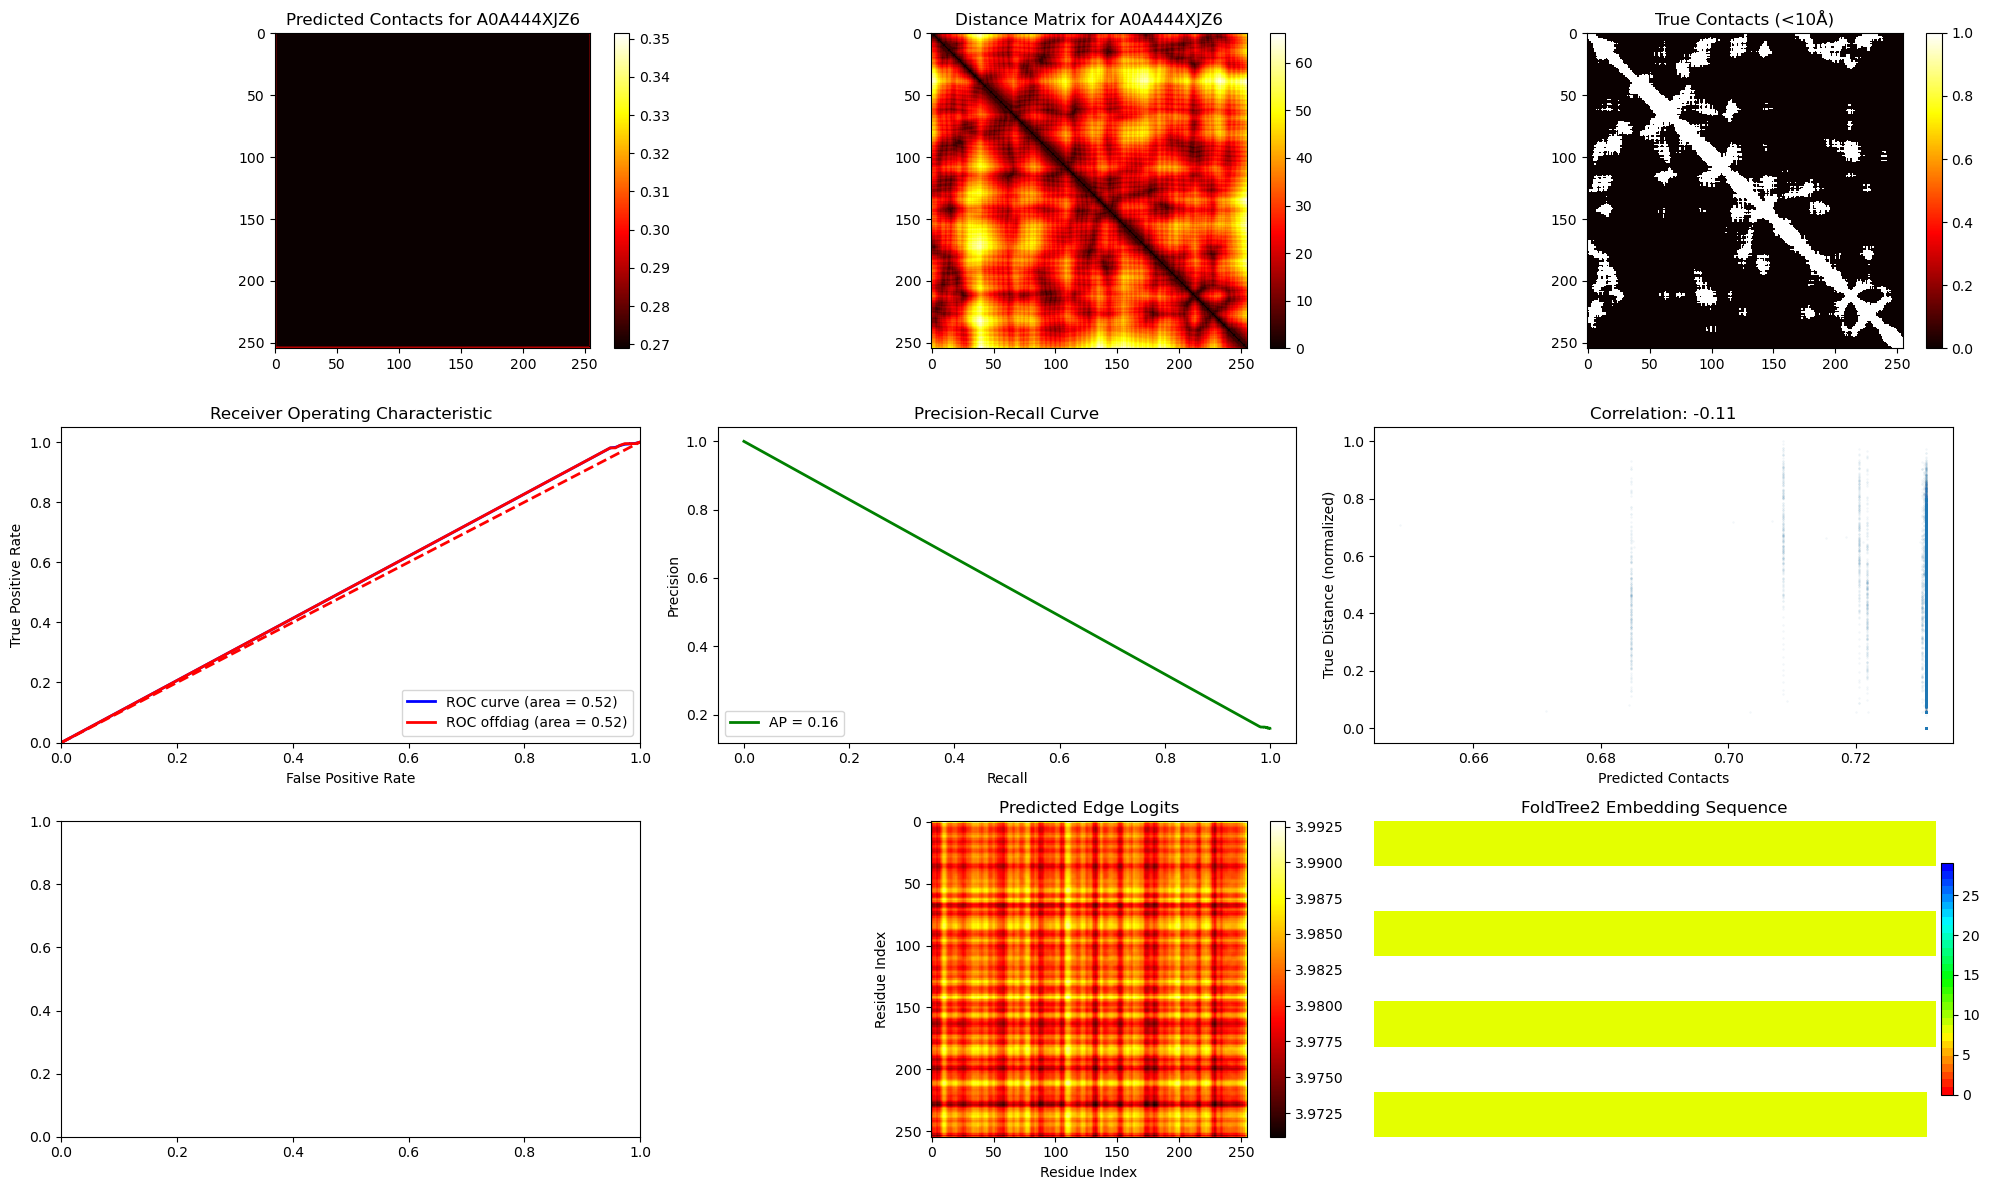

In [23]:
# Example usage: Visualize a single sample
# Get a random sample from the dataset
sample_idx = random.randint(0, len(struct_dat) - 1)
data_sample = struct_dat[sample_idx]

# Generate comprehensive visualization
fig, metrics , out = visualize_decoder_reconstruction(
	encoder, decoder, data_sample, device, num_embeddings, 
	converter, epoch=None, save_path='reconstruction_analysis.png'
)

print("\nPrediction Metrics:")
for key, value in metrics.items():
	print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

plt.show()

In [24]:
def adaptive_clip_grad(model, clip_factor=0.01, eps=1e-3, exclude_bias_norm=True):
	"""
	AGC (Adaptive Gradient Clipping).
	Scales gradients if grad_norm > clip_factor * param_norm.
	"""
	for p in model.parameters():
		if p.grad is None:
			continue
		if exclude_bias_norm and p.ndim == 1:
			# skip bias/LayerNorm weights
			continue
		param_norm = torch.norm(p.detach())
		grad_norm = torch.norm(p.grad.detach())
		max_norm = clip_factor * (param_norm + eps)
		if grad_norm > max_norm:
			scale = max_norm / (grad_norm + eps)
			p.grad.detach().mul_(scale)


In [25]:

train_loader = DataLoader(struct_dat, batch_size=batch_size, shuffle=True, num_workers=20)
encoder.train()
decoder.train()
hammingdistances = []
figurestack = []

import glob
if reload == True:
	if os.path.exists('models/notebook/') == False:
		print("No saved models found in 'models/notebook/' directory. Starting with new models.")
		os.mkdir('models/notebook/' )
	else:
		encoder_models = glob.glob('models/notebook/*encoder*.pt')
		decoder_models = glob.glob( 'models/notebook/*decoder*.pt')
		last_encoder = sorted(encoder_models, key=lambda x: int(x.split('_')[-1].split('.')[0]))[-1]
		last_decoder = sorted(decoder_models, key=lambda x: int(x.split('_')[-1].split('.')[0]))[-1]
		print(f"Reloading encoder from {last_encoder}")
		print(f"Reloading decoder from {last_decoder}")
		encoder = torch.load(last_encoder)
		decoder = torch.load(last_decoder)
		
		encoder = encoder.to(device)
		decoder = decoder.to(device)

		encoder.train()
		decoder.train()


/home/dmoi/miniforge3/envs/foldtree2/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [26]:
from foldtree2.src.losses.losses import ss_reconstruction_loss
train_loop1 = False
if train_loop1 == True:
	
	encoder = encoder.to(device)
	decoder = decoder.to(device)
	figurestack = []
	metrics_history = []  # Track metrics over time

	# Initialize GradScaler for mixed precision training
	scaler = GradScaler()

	print("Mixed Precision Training Enabled")
	print(f"Using device: {device}")

	for epoch in range(num_epochs):
		total_loss_x = 0
		total_loss_edge = 0
		total_vq = 0
		total_angles_loss = 0
		total_loss_fft2 = 0
		total_logit_loss = 0
		total_ss_loss = 0
		
		for batch_idx, data in enumerate(tqdm.notebook.tqdm(train_loader, desc=f"Epoch {epoch}")):
			data = data.to(device)
			
			# Forward pass with autocast for mixed precision
			with autocast():
				z, vqloss = encoder(data)
				data['res'].x = z
				
				# Forward pass through decoder
				out = decoder(data, None)
				edge_index = data.edge_index_dict.get(('res', 'contactPoints', 'res')) if hasattr(data, 'edge_index_dict') else None

				# Edge reconstruction loss
				logitloss = torch.tensor(0.0, device=device)
				edgeloss = torch.tensor(0.0, device=device)
				if edge_index is not None:
					edgeloss, logitloss = recon_loss_diag(data, edge_index, decoder, plddt=mask_plddt, key='edge_probs' , normalize = normalize_losses)
				
				# Amino acid reconstruction loss
				xloss = aa_reconstruction_loss(data['AA'].x, out['aa'], normalize = normalize_losses)
				
				# FFT2 loss
				fft2loss = torch.tensor(0.0, device=device)
				if 'fft2pred' in out and out['fft2pred'] is not None:
					fft2loss = F.smooth_l1_loss(torch.cat([data['fourier2dr'].x, data['fourier2di'].x], axis=1), out['fft2pred'])

				# Angles loss
				angles_loss = torch.tensor(0.0, device=device)
				if out.get('angles') is not None:
					angles_loss = angles_reconstruction_loss(out['angles'], data['bondangles'].x , plddt_mask=data['plddt'].x if mask_plddt else None, normalize = normalize_losses	)

				# Secondary structure loss
				ss_loss = torch.tensor(0.0, device=device)
				if out.get('ss_pred') is not None:
					if mask_plddt:
						mask = (data['plddt'].x >= plddt_threshold).squeeze()
						if mask.sum() > 0:
							ss_loss = F.cross_entropy(out['ss_pred'][mask], data['ss'].x[mask])
					else:
						ss_loss = F.cross_entropy(out['ss_pred'], data['ss'].x)
					
				#apply weight schedulers 

				"""
				xweight *= x_scheduler(step=epoch * len(train_loader) + batch_idx)
				edgeweight *= edge_scheduler(step=epoch * len(train_loader) + batch_idx)
				vqweight *= vq_scheduler(step=epoch * len(train_loader) + batch_idx )
				fft2weight *= fft2_scheduler(step=epoch * len(train_loader) + batch_idx)
				ss_weight *= ss_scheduler(step=epoch * len(train_loader) + batch_idx)
				angles_weight *= angles_scheduler(step=epoch * len(train_loader) + batch_idx)
				logitweight *= logit_scheduler(step=epoch * len(train_loader) + batch_idx)
				"""
				# Total loss
				loss = (xweight * xloss + edgeweight * edgeloss + vqweight * vqloss + 
						fft2weight * fft2loss + angles_weight * angles_loss + 
						ss_weight * ss_loss + logitweight * logitloss)
				
				# Scale loss by gradient accumulation steps
				loss = loss / gradient_accumulation_steps
			
			# Backward pass with gradient scaling
			scaler.scale(loss).backward()
			
			# Only update weights every gradient_accumulation_steps
			if (batch_idx + 1) % gradient_accumulation_steps == 0:
				if clip_grad:
					# Unscale gradients before clipping
					scaler.unscale_(optimizer)
					torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
					torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)
				
				# Step optimizer with scaler
				scaler.step(optimizer)
				scaler.update()
				optimizer.zero_grad()
				
				# Step scheduler if it's a step-based scheduler
				if scheduler_step_mode == 'step':
					scheduler.step()
			
			# Accumulate losses (unscaled for reporting)
			total_loss_x += xloss.item()
			total_logit_loss += logitloss.item()
			total_loss_edge += edgeloss.item()
			total_loss_fft2 += fft2loss.item()
			total_angles_loss += angles_loss.item()
			total_vq += vqloss.item() if isinstance(vqloss, torch.Tensor) else float(vqloss)
			total_ss_loss += ss_loss.item()
		
		# Clean up any remaining gradients at epoch end
		if len(train_loader) % gradient_accumulation_steps != 0:
			if clip_grad:
				scaler.unscale_(optimizer)
				torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
				torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)
			scaler.step(optimizer)
			scaler.update()
			optimizer.zero_grad()

		# Update learning rate for epoch-based schedulers (after each epoch)
		if scheduler_step_mode == 'epoch':
			if scheduler_type == 'plateau':
				scheduler.step(total_loss_x)  # ReduceLROnPlateau needs a metric
			else:
				scheduler.step()
		
		# Get current learning rate for logging
		current_lr = optimizer.param_groups[0]['lr']
		
		denominator = len(train_loader) if normalize_losses is False else 1.0
		# Compute average losses
		avg_losses = {
			'aa_loss': total_loss_x / denominator,
			'edge_loss': total_loss_edge / denominator,
			'vq_loss': total_vq / denominator,
			'fft2_loss': total_loss_fft2 / denominator,
			'angles_loss': total_angles_loss / denominator,
			'ss_loss': total_ss_loss / denominator,
			'logit_loss': total_logit_loss / denominator
		}
		
		# Print epoch summary
		print(f"\n{'='*80}")
		print(f"Epoch {epoch}/{num_epochs-1} | Learning Rate: {current_lr:.2e}")
		print(f"{'='*80}")
		print(f"  AA Loss:     {avg_losses['aa_loss']:.4f}")
		print(f"  Edge Loss:   {avg_losses['edge_loss']:.4f}")
		print(f"  VQ Loss:     {avg_losses['vq_loss']:.4f}")
		print(f"  FFT2 Loss:   {avg_losses['fft2_loss']:.4f}")
		print(f"  Angles Loss: {avg_losses['angles_loss']:.4f}")
		print(f"  SS Loss:     {avg_losses['ss_loss']:.4f}")
		print(f"  Logit Loss:  {avg_losses['logit_loss']:.4f}")
		
		# Save checkpoints and visualize every 10 epochs
		if epoch % 1 == 0:
			print(f"\n{'─'*80}")
			print(f"Saving checkpoint at epoch {epoch}...")
			print(f"{'─'*80}")
			
			# Save models
			os.makedirs('models/notebook', exist_ok=True)
			torch.save(encoder.state_dict(), f'models/notebook/encoder_epoch_{epoch}.pth')
			torch.save(decoder.state_dict(), f'models/notebook/decoder_epoch_{epoch}.pth')
			torch.save( encoder, f'models/notebook/encoder_full_epoch_{epoch}.pt' , weights_only = False )
			torch.save( decoder, f'models/notebook/decoder_full_epoch_{epoch}.pt' , weights_only = False )

			# Generate visualization
			print(f"Generating reconstruction visualization...")
			os.makedirs('figures', exist_ok=True)
			fig, metrics , sample_output = visualize_decoder_reconstruction(
				encoder, decoder, data_sample, device, num_embeddings, 
				converter, epoch=epoch, save_path=f'figures/reconstruction_epoch_{epoch}.png'
			)
			
			figurestack.append(fig)
			# Add epoch info to metrics
			metrics['epoch'] = epoch
			metrics.update(avg_losses)
			metrics_history.append(metrics)
			
			# Print reconstruction metrics
			print(f"\nReconstruction Metrics:")
			print(f"  ROC AUC (all):      {metrics['roc_auc']:.4f}")
			print(f"  ROC AUC (offdiag):  {metrics['roc_auc_offdiag']:.4f}")
			print(f"  Average Precision:  {metrics['average_precision']:.4f}")
			print(f"  Correlation:        {metrics['correlation']:.4f}")
			print(f"  Num Residues:       {metrics['num_residues']}")
			
			plt.show()
			print()

	print("\n" + "="*80)
	print("Training Complete!")
	print("="*80)
	print(f"Generated {len(figurestack)} visualization figures")
	print(f"\nMetrics Summary Across Training:")
	print(f"{'─'*80}")
	for i, m in enumerate(metrics_history):
		print(f"Epoch {m['epoch']:3d}: ROC AUC={m['roc_auc']:.4f}, AP={m['average_precision']:.4f}, Corr={m['correlation']:.4f}")


────────────────────────────────────────────────────────────────────────────────
Saving checkpoint at epoch 55...
────────────────────────────────────────────────────────────────────────────────
Generating reconstruction visualization...
Sequence Hamming Distance: 0.345 (88 mismatches)
Saved figure to figures/reconstruction_epoch_55.png

Epoch 55/299 | Learning Rate: 2.50e-06
  AA Loss:     0.7106
  Edge Loss:   1.1276
  VQ Loss:     0.1046
  FFT2 Loss:   0.0000
  Angles Loss: 0.0000
  SS Loss:     0.0000
  Logit Loss:  4.1533

Reconstruction Metrics:
  ROC AUC (all):      0.8040
  ROC AUC (offdiag):  0.7668
  Average Precision:  0.4196
  Correlation:        -0.5215
  Num Residues:       255


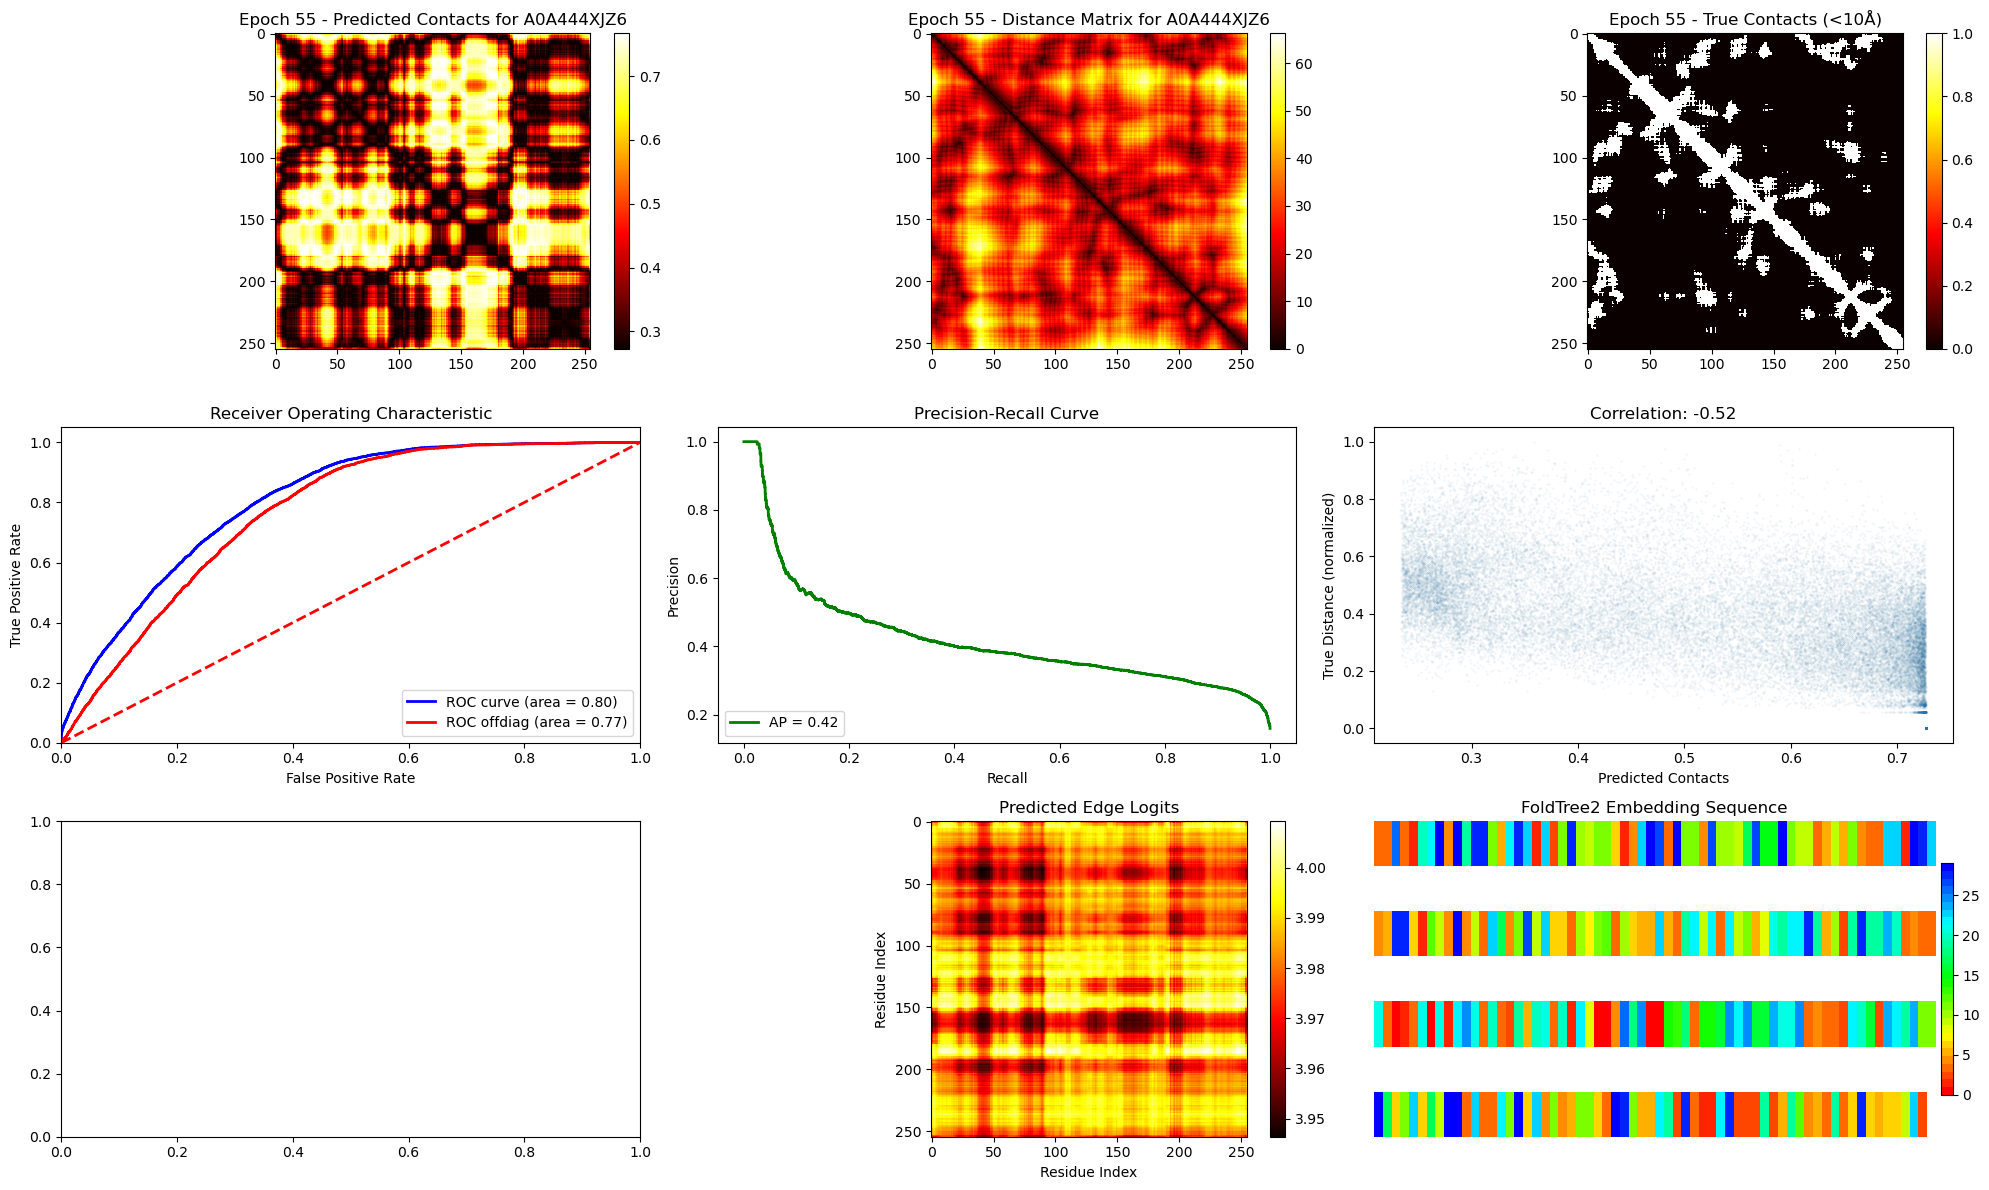

Epoch 56:   0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_3633361/1958153049.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [ ]:
from foldtree2.src.losses.losses import ss_reconstruction_loss
from IPython.display import clear_output

#add params to training params

encoder = encoder.to(device)
decoder = decoder.to(device)
uncertainy_weighting = uncertainy_weighting.to(device)

figurestack = []
metrics_history = []  # Track metrics over time
# Initialize GradScaler for mixed precision training
scaler = GradScaler()
print("Mixed Precision Training Enabled")
print(f"Using device: {device}")

for epoch in range(num_epochs):
	total_loss_x = 0
	total_loss_edge = 0
	total_vq = 0
	total_angles_loss = 0
	total_loss_fft2 = 0
	total_logit_loss = 0
	total_ss_loss = 0
	active_losses = []
	
	for batch_idx, data in enumerate(tqdm.notebook.tqdm(train_loader, desc=f"Epoch {epoch}")):
		data = data.to(device)
		
		# Forward pass with autocast for mixed precision
		with autocast():
			z, vqloss = encoder(data)
			if normalize_losses:
				active_losses.append(2)  # VQ loss index
			data['res'].x = z
			# Forward pass through decoder
			out = decoder(data, None)
			edge_index = data.edge_index_dict.get(('res', 'contactPoints', 'res')) if hasattr(data, 'edge_index_dict') else None

			# Edge reconstruction loss
			logitloss = torch.tensor(0.0, device=device)
			edgeloss = torch.tensor(0.0, device=device)
			if edge_index is not None:
				edgeloss, logitloss = recon_loss_diag(data, edge_index, decoder, plddt=mask_plddt, key='edge_probs' , normalize = normalize_losses)
				if normalize_losses:
					active_losses.append(1)  # Edge loss index
			
			# Amino acid reconstruction loss
			xloss = aa_reconstruction_loss(data['AA'].x, out['aa'], normalize = normalize_losses)
			if normalize_losses:
				active_losses.append(0)  # Amino acid loss index
			
			# FFT2 loss
			fft2loss = torch.tensor(0.0, device=device)
			if 'fft2pred' in out and out['fft2pred'] is not None:
				fft2loss = F.smooth_l1_loss(torch.cat([data['fourier2dr'].x, data['fourier2di'].x], axis=1), out['fft2pred'])
				if normalize_losses:
					active_losses.append(3)  # FFT2 loss index
			# Angles loss
			angles_loss = torch.tensor(0.0, device=device)
			if out.get('angles') is not None:
				angles_loss = angles_reconstruction_loss(out['angles'], data['bondangles'].x , plddt_mask=data['plddt'].x if mask_plddt else None, normalize = normalize_losses	)
				if normalize_losses:
					active_losses.append(4)  # Angles loss index
			# Secondary structure loss
			ss_loss = torch.tensor(0.0, device=device)
			if out.get('ss_pred') is not None:
				if mask_plddt:
					mask = (data['plddt'].x >= plddt_threshold).squeeze()
					if mask.sum() > 0:
						ss_loss = F.cross_entropy(out['ss_pred'][mask], data['ss'].x[mask])
				else:
					ss_loss = F.cross_entropy(out['ss_pred'], data['ss'].x)
			
			if use_uncertainty_weighting:# and batch_idx > warmup_steps:  # Skip uncertainty weighting for first batches to avoid instability
				loss = uncertainy_weighting.forward( torch.stack([xloss*xweight, edgeloss*edgeweight , vqloss*vqweight, fft2loss*fft2weight, angles_loss*angles_weight, ss_loss*ss_weight, logitloss*logitweight ]) , active = active_losses)
			else:
				 loss =  (xweight * xloss + edgeweight * edgeloss + vqweight * vqloss + 
						fft2weight * fft2loss + angles_weight * angles_loss + 
						ss_weight * ss_loss + logitweight * logitloss)
			
			# Scale loss by gradient accumulation steps
			loss = loss / gradient_accumulation_steps
		
		# Backward pass with gradient scaling
		scaler.scale(loss).backward()
		
		# Only update weights every gradient_accumulation_steps
		if (batch_idx + 1) % gradient_accumulation_steps == 0:
			if clip_grad:
				# Unscale gradients before clipping
				scaler.unscale_(optimizer)
				torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
				torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)
			
			# Step optimizer with scaler
			scaler.step(optimizer)
			scaler.update()
			optimizer.zero_grad()
			
			# Step scheduler if it's a step-based scheduler
			if scheduler_step_mode == 'step':
				scheduler.step()
		
		# Accumulate losses (unscaled for reporting)
		total_loss_x += xloss.item()
		total_logit_loss += logitloss.item()
		total_loss_edge += edgeloss.item()
		total_loss_fft2 += fft2loss.item()
		total_angles_loss += angles_loss.item()
		total_vq += vqloss.item() if isinstance(vqloss, torch.Tensor) else float(vqloss)
		total_ss_loss += ss_loss.item()
	
	#after 25 epochs, ramp up xloss weight to stabilize training
	if epoch > 20:
		xweight = .5
		#ss_weight = .5
		print("Ramping up amino acid loss weight to .5 for stable training")

	# Clean up any remaining gradients at epoch end
	if len(train_loader) % gradient_accumulation_steps != 0:
		if clip_grad:
			scaler.unscale_(optimizer)
			torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
			torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)
		scaler.step(optimizer)
		scaler.update()
		optimizer.zero_grad()

	# Update learning rate for epoch-based schedulers (after each epoch)
	if scheduler_step_mode == 'epoch':
		if scheduler_type == 'plateau':
			scheduler.step(total_loss_x)  # ReduceLROnPlateau needs a metric
		else:
			scheduler.step()
	
	# Get current learning rate for logging
	current_lr = optimizer.param_groups[0]['lr']
	
	denominator = len(train_loader)# if normalize_losses is False else 1.0
	# Compute average losses
	avg_losses = {
		'aa_loss': total_loss_x / denominator,
		'edge_loss': total_loss_edge / denominator,
		'vq_loss': total_vq / denominator,
		'fft2_loss': total_loss_fft2 / denominator,
		'angles_loss': total_angles_loss / denominator,
		'ss_loss': total_ss_loss / denominator,
		'logit_loss': total_logit_loss / denominator
	}
	
	
	
	# Save checkpoints and visualize every 10 epochs
	if epoch % 1 == 0:

		#clear previous figures to save memory
		plt.close('all')
		#clear ipython output to save memory
		clear_output(wait=True)

		print(f"\n{'─'*80}")
		print(f"Saving checkpoint at epoch {epoch}...")
		print(f"{'─'*80}")
		
		# Save models
		os.makedirs('models', exist_ok=True)
		os.makedirs('models/notebook', exist_ok=True)
		torch.save(encoder.state_dict(), f'models/notebook/encoder_epoch_{epoch}.pth')
		torch.save(decoder.state_dict(), f'models/notebook/decoder_epoch_{epoch}.pth')
		torch.save( encoder, f'models/notebook/encoder_full_epoch_{epoch}.pt' )
		torch.save( decoder, f'models/notebook/decoder_full_epoch_{epoch}.pt' )

		# Generate visualization
		print(f"Generating reconstruction visualization...")
		os.makedirs('figures', exist_ok=True)
		fig, metrics , sample_output = visualize_decoder_reconstruction(
			encoder, decoder, data_sample, device, num_embeddings, 
			converter, epoch=epoch, save_path=f'figures/reconstruction_epoch_{epoch}.png'
		)
		
		figurestack.append(fig)
		# Add epoch info to metrics
		metrics['epoch'] = epoch
		metrics.update(avg_losses)
		metrics_history.append(metrics)

		# Print epoch summary
		print(f"\n{'='*80}")
		print(f"Epoch {epoch}/{num_epochs-1} | Learning Rate: {current_lr:.2e}")
		print(f"{'='*80}")
		print(f"  AA Loss:     {avg_losses['aa_loss']:.4f}")
		print(f"  Edge Loss:   {avg_losses['edge_loss']:.4f}")
		print(f"  VQ Loss:     {avg_losses['vq_loss']:.4f}")
		print(f"  FFT2 Loss:   {avg_losses['fft2_loss']:.4f}")
		print(f"  Angles Loss: {avg_losses['angles_loss']:.4f}")
		print(f"  SS Loss:     {avg_losses['ss_loss']:.4f}")
		print(f"  Logit Loss:  {avg_losses['logit_loss']:.4f}")
		
		# Print reconstruction metrics
		print(f"\nReconstruction Metrics:")
		print(f"  ROC AUC (all):      {metrics['roc_auc']:.4f}")
		print(f"  ROC AUC (offdiag):  {metrics['roc_auc_offdiag']:.4f}")
		print(f"  Average Precision:  {metrics['average_precision']:.4f}")
		print(f"  Correlation:        {metrics['correlation']:.4f}")
		print(f"  Num Residues:       {metrics['num_residues']}")
		
		plt.show()
		print()

print("\n" + "="*80)
print("Training Complete!")
print("="*80)
print(f"Generated {len(figurestack)} visualization figures")
print(f"\nMetrics Summary Across Training:")
print(f"{'─'*80}")
for i, m in enumerate(metrics_history):
	print(f"Epoch {m['epoch']:3d}: ROC AUC={m['roc_auc']:.4f}, AP={m['average_precision']:.4f}, Corr={m['correlation']:.4f}")


In [ ]:
# Plot training metrics over epochs
if len(metrics_history) > 0:
	fig, axes = plt.subplots(3, 3, figsize=(18, 14))
	fig.suptitle('Training Metrics Over Time', fontsize=16, fontweight='bold')
	
	# Extract data
	epochs = [m['epoch'] for m in metrics_history]
	roc_auc = [m['roc_auc'] for m in metrics_history]
	roc_auc_offdiag = [m['roc_auc_offdiag'] for m in metrics_history]
	avg_precision = [m['average_precision'] for m in metrics_history]
	correlation = [m['correlation'] for m in metrics_history]
	aa_loss = [m['aa_loss'] for m in metrics_history]
	edge_loss = [m['edge_loss'] for m in metrics_history]
	angles_loss = [m['angles_loss'] for m in metrics_history]
	ss_loss = [m['ss_loss'] for m in metrics_history]
	
	# ROC AUC
	axes[0, 0].plot(epochs, roc_auc, 'b-o', label='All residues', linewidth=2)
	axes[0, 0].plot(epochs, roc_auc_offdiag, 'r-s', label='Off-diagonal', linewidth=2)
	axes[0, 0].set_xlabel('Epoch')
	axes[0, 0].set_ylabel('ROC AUC')
	axes[0, 0].set_title('ROC AUC Score')
	axes[0, 0].legend()
	axes[0, 0].grid(True, alpha=0.3)
	
	# Average Precision
	axes[0, 1].plot(epochs, avg_precision, 'g-o', linewidth=2)
	axes[0, 1].set_xlabel('Epoch') 
	axes[0, 1].set_ylabel('Average Precision')
	axes[0, 1].set_title('Average Precision Score')
	axes[0, 1].grid(True, alpha=0.3)
	
	# Correlation
	axes[0, 2].plot(epochs, correlation, 'purple', marker='o', linewidth=2)
	axes[0, 2].set_xlabel('Epoch')
	axes[0, 2].set_ylabel('Correlation')
	axes[0, 2].set_title('Prediction-Distance Correlation')
	axes[0, 2].grid(True, alpha=0.3)
	
	# AA Loss
	axes[1, 0].plot(epochs, aa_loss, 'orange', marker='o', linewidth=2)
	axes[1, 0].set_xlabel('Epoch')
	axes[1, 0].set_ylabel('AA Loss')
	axes[1, 0].set_title('Amino Acid Reconstruction Loss')
	axes[1, 0].grid(True, alpha=0.3)
	
	# Edge Loss
	axes[1, 1].plot(epochs, edge_loss, 'cyan', marker='o', linewidth=2)
	axes[1, 1].set_xlabel('Epoch')
	axes[1, 1].set_ylabel('Edge Loss')
	axes[1, 1].set_title('Contact Prediction Loss')
	axes[1, 1].grid(True, alpha=0.3)
	
	# Angles Loss
	axes[1, 2].plot(epochs, angles_loss, 'red', marker='o', linewidth=2)
	axes[1, 2].set_xlabel('Epoch')
	axes[1, 2].set_ylabel('Angles Loss')
	axes[1, 2].set_title('Bond Angles Reconstruction Loss')
	axes[1, 2].grid(True, alpha=0.3)
	
	# SS Loss
	axes[2, 0].plot(epochs, ss_loss, 'brown', marker='o', linewidth=2)
	axes[2, 0].set_xlabel('Epoch')
	axes[2, 0].set_ylabel('SS Loss')
	axes[2, 0].set_title('Secondary Structure Prediction Loss')
	axes[2, 0].grid(True, alpha=0.3)
	
	# Combined metrics table
	axes[2, 1].axis('off')
	table_data = []
	for m in metrics_history:
		table_data.append([
			f"{m['epoch']}",
			f"{m['roc_auc']:.3f}",
			f"{m['average_precision']:.3f}",
			f"{m['correlation']:.3f}"
		])
	
	table = axes[2, 1].table(
		cellText=table_data,
		colLabels=['Epoch', 'ROC AUC', 'Avg Prec', 'Corr'],
		loc='center',
		cellLoc='center'
	)
	table.auto_set_font_size(False)
	table.set_fontsize(9)
	table.scale(1, 2)
	axes[2, 1].set_title('Metrics Summary')
	
	# VQ Loss
	vq_loss = [m['vq_loss'] for m in metrics_history]
	axes[2, 2].plot(epochs, vq_loss, 'magenta', marker='o', linewidth=2)
	axes[2, 2].set_xlabel('Epoch')
	axes[2, 2].set_ylabel('VQ Loss')
	axes[2, 2].set_title('Vector Quantization Loss')
	axes[2, 2].grid(True, alpha=0.3)
	
	plt.tight_layout()
	plt.savefig('figures/training_metrics_summary.png', dpi=150, bbox_inches='tight')
	plt.show()
	
	print(f"\nSaved training metrics summary to figures/training_metrics_summary.png")
else:
	print("No metrics history available. Train for at least one checkpoint epoch.")

NameError: name 'metrics_history' is not defined

In [ ]:
def load_and_visualize_pdb(pdb_path, encoder, decoder, converter, device, num_embeddings, 
						  save_path=None, figsize=(20, 12)):
	"""
	Load any PDB file, process it through the encoder-decoder, and visualize results.
	
	Args:
		pdb_path: Path to PDB file
		encoder: Trained encoder model
		decoder: Trained decoder model
		converter: PDB2PyG converter
		device: PyTorch device
		num_embeddings: Number of embeddings in alphabet
		save_path: Optional path to save figure
		figsize: Figure size tuple
		
	Returns:
		fig: matplotlib figure
		metrics_dict: computed metrics
		zdiscrete: discrete embeddings
		data_sample: processed data
	"""
	import os
	from foldtree2.src import pdbgraph
	
	print(f"Loading PDB file: {pdb_path}")
	
	# Check if file exists
	if not os.path.exists(pdb_path):
		raise FileNotFoundError(f"PDB file not found: {pdb_path}")
	
	# Convert PDB to PyG data
	try:
		# Use converter to process the PDB file
		data_sample = converter.pdb2pyg(pdb_path)
		print(f"Successfully converted PDB to PyG format")
		print(f"Protein has {data_sample['res'].x.shape[0]} residues")
		
	except Exception as e:
		print(f"Error converting PDB file: {e}")
		return None, None, None, None
	
	# Set identifier from filename if not present
	if not hasattr(data_sample, 'identifier'):
		filename = os.path.basename(pdb_path).replace('.pdb', '')
		data_sample.identifier = filename
	
	# Move to device and encode
	data_sample = data_sample.to(device)
	encoder.eval()
	decoder.eval()
	
	with torch.no_grad():
		try:
			z, vqloss = encoder(data_sample)
			ords = encoder.vector_quantizer.discretize_z(z.detach())
			zdiscrete = ords[0].detach()
			print(f"Encoded to {zdiscrete.shape[0]} discrete tokens")
			
		except Exception as e:
			print(f"Error during encoding: {e}")
			return None, None, None, None
	
	# Visualize using the existing function
	fig, metrics = visualize_decoder_reconstruction(
		encoder, decoder, data_sample, device, num_embeddings,
		converter, epoch=None, save_path=save_path, figsize=figsize
	)
	
	return fig, metrics, zdiscrete, data_sample

def load_pdb_from_identifier(identifier, encoder, decoder, converter, device, num_embeddings,
							structfolder='tmp/', save_path=None, figsize=(20, 12)):
	"""
	Load PDB from AlphaFold DB using identifier and visualize.
	
	Args:
		identifier: Protein identifier (e.g., 'AF-P12345-F1')
		encoder, decoder, converter, device, num_embeddings: Model components
		structfolder: Folder to download PDB to
		save_path, figsize: Visualization options
		
	Returns:
		Same as load_and_visualize_pdb
	"""
	from foldtree2.src.AFDB_tools import grab_struct
	
	# Download structure
	grab_struct(identifier, structfolder=structfolder)
	pdb_path = os.path.join(structfolder, f"{identifier}.pdb")
	
	return load_and_visualize_pdb(pdb_path, encoder, decoder, converter, device, 
								 num_embeddings, save_path, figsize)

def visualize_pdb_with_embeddings(pdb_path, zdiscrete, num_embeddings, width=800, height=400):
	"""
	Visualize PDB structure colored by embedding states using py3Dmol.
	
	Args:
		pdb_path: Path to PDB file
		zdiscrete: Discrete embedding tensor
		num_embeddings: Number of embeddings
		width, height: Viewer dimensions
		
	Returns:
		py3Dmol view object
	"""
	import py3Dmol
	import colour
	import numpy as np
	
	# Read PDB file
	with open(pdb_path, 'r') as f:
		pdb_data = f.read()
	
	# Create color mapping
	ord_colors = colour.Color("red").range_to(colour.Color("blue"), num_embeddings)
	ord_colors = np.array([c.get_rgb() for c in ord_colors])
	sequence_colors = ord_colors[zdiscrete.cpu().numpy()]
	sequence_colors_hex = [colour.Color(rgb=tuple(c)).hex for c in sequence_colors]
	
	# Create 3D viewer
	view = py3Dmol.view(width=width, height=height)
	view.addModel(pdb_data, 'pdb')
	
	# Color by embedding state
	for i, color in enumerate(sequence_colors_hex):
		view.setStyle({'chain': 'A', 'resi': i+1}, {'cartoon': {'color': color}})
	
	view.setBackgroundColor('0xeeeeee')
	view.zoomTo()
	
	return view

def batch_process_pdbs(pdb_folder, encoder, decoder, converter, device, num_embeddings,
					  output_folder='batch_results/', file_pattern='*.pdb'):
	"""
	Process multiple PDB files in a folder.
	
	Args:
		pdb_folder: Folder containing PDB files
		encoder, decoder, converter, device, num_embeddings: Model components
		output_folder: Where to save results
		file_pattern: File pattern to match (e.g., '*.pdb')
		
	Returns:
		results_dict: Dictionary with results for each file
	"""
	import glob
	import os
	
	# Create output folder
	os.makedirs(output_folder, exist_ok=True)
	
	# Find PDB files
	pdb_files = glob.glob(os.path.join(pdb_folder, file_pattern))
	print(f"Found {len(pdb_files)} PDB files to process")
	
	results = {}
	
	for pdb_file in pdb_files:
		filename = os.path.basename(pdb_file).replace('.pdb', '')
		print(f"\nProcessing: {filename}")
		
		try:
			# Process PDB
			save_path = os.path.join(output_folder, f"{filename}_reconstruction.png")
			fig, metrics, zdiscrete, data_sample = load_and_visualize_pdb(
				pdb_file, encoder, decoder, converter, device, num_embeddings,
				save_path=save_path
			)
			
			if fig is not None:
				results[filename] = {
					'metrics': metrics,
					'zdiscrete': zdiscrete,
					'data_sample': data_sample,
					'pdb_path': pdb_file,
					'figure_path': save_path
				}
				plt.close(fig)  # Free memory
				
		except Exception as e:
			print(f"Error processing {filename}: {e}")
			results[filename] = {'error': str(e)}
	
	return results

# Usage examples:
"""
# Load a specific PDB file
fig, metrics, zdiscrete, data = load_and_visualize_pdb(
	'/path/to/protein.pdb', encoder, decoder, converter, device, num_embeddings
)

# Load from AlphaFold DB
fig, metrics, zdiscrete, data = load_pdb_from_identifier(
	'AF-P00520-F1', encoder, decoder, converter, device, num_embeddings
)

# Visualize with 3D coloring
view = visualize_pdb_with_embeddings('/path/to/protein.pdb', zdiscrete, num_embeddings)
view.show()

# Process multiple PDBs
results = batch_process_pdbs(
	'/path/to/pdb_folder/', encoder, decoder, converter, device, num_embeddings
)
"""

"\n# Load a specific PDB file\nfig, metrics, zdiscrete, data = load_and_visualize_pdb(\n\t'/path/to/protein.pdb', encoder, decoder, converter, device, num_embeddings\n)\n\n# Load from AlphaFold DB\nfig, metrics, zdiscrete, data = load_pdb_from_identifier(\n\t'AF-P00520-F1', encoder, decoder, converter, device, num_embeddings\n)\n\n# Visualize with 3D coloring\nview = visualize_pdb_with_embeddings('/path/to/protein.pdb', zdiscrete, num_embeddings)\nview.show()\n\n# Process multiple PDBs\nresults = batch_process_pdbs(\n\t'/path/to/pdb_folder/', encoder, decoder, converter, device, num_embeddings\n)\n"

In [ ]:
# Add this cell to test loading arbitrary PDB files
def interactive_pdb_loader():
	"""Interactive widget to load and visualize PDB files"""
	import ipywidgets as widgets
	from IPython.display import display
	
	# File upload widget
	file_upload = widgets.FileUpload(
		accept='.pdb',
		multiple=False,
		description='Upload PDB'
	)
	
	# Identifier input
	identifier_input = widgets.Text(
		value='',
		placeholder='Enter AlphaFold ID (e.g., AF-P00520-F1)',
		description='AF ID:'
	)
	
	# Buttons
	upload_btn = widgets.Button(description="Process Uploaded PDB")
	download_btn = widgets.Button(description="Download and Process")
	
	# Output
	output = widgets.Output()
	
	def process_uploaded(b):
		with output:
			output.clear_output()
			if file_upload.value:
				# Save uploaded file
				uploaded_file = list(file_upload.value.values())[0]
				temp_path = f"tmp/{uploaded_file['metadata']['name']}"
				with open(temp_path, 'wb') as f:
					f.write(uploaded_file['content'])
				
				# Process
				fig, metrics, zdiscrete, data = load_and_visualize_pdb(
					temp_path, encoder, decoder, converter, device, num_embeddings
				)
				
				if fig:
					plt.show()
					print("Metrics:", metrics)
					
					# Show 3D structure
					view = visualize_pdb_with_embeddings(temp_path, zdiscrete, num_embeddings)
					view.show()
	
	def process_identifier(b):
		with output:
			output.clear_output()
			if identifier_input.value:
				fig, metrics, zdiscrete, data = load_pdb_from_identifier(
					identifier_input.value, encoder, decoder, converter, device, num_embeddings
				)
				
				if fig:
					plt.show()
					print("Metrics:", metrics)
					
					# Show 3D structure  
					pdb_path = f"tmp/{identifier_input.value}.pdb"
					view = visualize_pdb_with_embeddings(pdb_path, zdiscrete, num_embeddings)
					view.show()
	
	upload_btn.on_click(process_uploaded)
	download_btn.on_click(process_identifier)
	
	display(widgets.VBox([
		widgets.HTML("<h3>Load PDB File</h3>"),
		file_upload,
		upload_btn,
		widgets.HTML("<h3>Or Download from AlphaFold DB</h3>"),
		identifier_input,
		download_btn,
		output
	]))

# Run the interactive loader
# interactive_pdb_loader()

In [ ]:
print( figurestack)

[]


In [ ]:
#save last figure in the figurestack as svg
figurestack[-1].savefig('test_monodecoder_last_figure.svg', format='svg')
#save each subplot within the last figure as a separate svg
for i, ax in enumerate(figurestack[-1].axes):
	ax.figure.savefig(f'test_monodecoder_last_figure_subplot_{i}.svg', format='svg')


IndexError: list index out of range

In [ ]:
#show the structure for the data sample
grab_struct(str(data_sample.identifier) , structfolder='tmp/')
import py3Dmol
with open('tmp/' + str(data_sample.identifier) + '.pdb', 'r') as f:
	pdb_data = f.read()
view = py3Dmol.view(width=800, height=400)
view.addModel(pdb_data, 'pdb')
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.setBackgroundColor('0xeeeeee')
view.zoomTo()
view.show()

In [ ]:
#color the structure by state of ft2 alphabet
#map the zdiscrete to colors


num_embeddings = encoder.num_embeddings
ord_colors = colour.Color("red").range_to(colour.Color("blue"), num_embeddings)
ord_colors = np.array([c.get_rgb() for c in ord_colors])
sequence_colors = ord_colors[zdiscrete.cpu().numpy()]
#convert to hex
sequence_colors_hex = [colour.Color(rgb=tuple(c)).hex for c in sequence_colors]
print(sequence_colors_hex)
#add the colors to the structure
for i, color in enumerate(sequence_colors_hex):
	view.setStyle({'chain': 'A', 'resi': i+1}, {'cartoon': {'color': color}})
view.zoomTo()
view.show()